DATA 612 PWS1 AQI Deep Learning Group Final Project

Group Members: Alima Suleimenova, Mahammad Afandiyev, Noah Shaw, Dan Ding, Aaron Kim

# <b>Project Overview & Configuration</b>
*   Best Leak-Free Global Model (60→7)
*   Global model + country embedding + calendar features
*   Causal (forward-fill only), time-ordered splits
*   Robust reporting

In [38]:
import sys, subprocess, os, glob, math, random, warnings, json, zipfile

warnings.filterwarnings("ignore")

def _pip(pkg):
    try:
        _import_(pkg.split("==")[0].split(">=")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for p in ["kagglehub", "kaggle", "pandas", "numpy", "torch", "scikit-learn", "matplotlib", "seaborn"]:
    _pip(p)

import kagglehub
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from copy import deepcopy
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {DEVICE}")

# Data/windowing Variables
LOOKBACK       = 60
PRED_LEN       = 7
VAL_DAYS       = 28
TEST_DAYS      = 28
MAX_CONSEC_GAP = 7
FORCE_COUNTRY_GROUPING = True   # prefer country over city for 'group'

# Training Variables
BATCH_SIZE     = 96
EPOCHS         = 40
LR             = 3e-4
WEIGHT_DECAY   = 1e-4
CLIP_NORM      = 1.0
PATIENCE       = 6
FACTOR         = 0.5
MIN_LR         = 1e-6

# Loss shaping Variables
CORR_L2        = 3e-4     # correction L2 penalty (stability)
SLOPE_K        = 0.02     # relax penalty on steep slopes
ERR_SLOPE_LMB  = 0.35     # upweight loss on steep windows
HORIZ_WEIGHTS  = np.linspace(1.20, 1.00, PRED_LEN).astype(np.float32)  # H1 > H7

# Model Variables
D_MODEL        = 256
N_HEADS        = 8
LAYERS         = 4
D_FF           = 512
PATCH          = 7
STRIDE         = 2
DECOMP_K       = 21
DROPOUT        = 0.10
USE_REVIN      = True
USE_FOURIER    = False
POS_CAP        = 2048
USE_GROUP_EMB  = True
USE_CALENDAR   = True

OUTDIR = "./aqi_outputs"  # created on demand

# Experiment sweep configuration
SWEEP_BATCH_SIZES = [32, 64, 96, 128]
SWEEP_LOOKBACKS   = [7, 30, 60]

# Get appropriate OBS_THRESHOLD value based on the LOOKBACK value during experiments
def get_obs_threshold(lb: int) -> int:
    """Return OBS_THRESHOLD based on LOOKBACK per project spec."""
    return 100 if lb == 7 else 123


 Using device: cuda


In [ ]:
# List the packages you actually import/use in the notebook:
PKGS = {
    "numpy": "numpy",
    "pandas": "pandas",
    "torch": "torch",
    "scikit-learn": "sklearn",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "kaggle": "kaggle",
    "kagglehub": "kagglehub",
}

import importlib
from importlib import metadata

rows = []
for pip_name, mod_name in PKGS.items():
    try:
        m = importlib.import_module(mod_name)
        ver = getattr(m, "__version__", None) or metadata.version(pip_name)
        status = "OK"
    except Exception as e:
        ver = f"NOT INSTALLED"
        status = f"Err: {e.__class__.__name__}"
    rows.append((pip_name, mod_name, ver, status))

# Pretty print
from pprint import pprint
print("Package versions in this environment:\n(pip_name, module_import, version, status)")
pprint(rows, compact=True)

# Optional: show Python and hardware info
import sys, platform
print("\nPython:", sys.version.split()[0], "| Platform:", platform.platform())
try:
    import torch
    print("Torch:", torch.__version__,
          "| CUDA:", torch.version.cuda,
          "| cuDNN:", torch.backends.cudnn.version(),
          "| GPU available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
except Exception:
    pass


# 1. Data Fetch
> Kaggle download + extraction



In [39]:
# Loading data from Kaggle
path = kagglehub.dataset_download("azminetoushikwasi/aqi-air-quality-index-scheduled-daily-update")

csv_path = os.path.join(path, "data_date.csv")

df = pd.read_csv(csv_path)
df.head()

,Date,Country,Status,AQI Value
0,2022-07-21,Albania,Good,14
1,2022-07-21,Algeria,Moderate,65
2,2022-07-21,Andorra,Moderate,55
3,2022-07-21,Angola,Unhealthy for Sensitive Groups,113
4,2022-07-21,Argentina,Moderate,63


# 2. Schema & Ingest
> Standardize columns, read all CSVs, sanity filters

In [40]:
data = df.rename(columns={"AQI Value": "aqi"})

data["date"] = pd.to_datetime(data["Date"], errors="coerce", utc=False).dt.tz_localize(None)
data.drop(columns='Date', inplace=True)

data = data.rename(columns={"Country": "group"})
data.drop(columns='Status', inplace=True)
data = data[["date", "aqi", "group"]]
data.head()

AQI_MIN = 1
AQI_MAX = 500


Summary Statistics:
                                 date           aqi
count                          20741  20741.000000
mean   2023-08-19 06:42:53.337833216     62.840075
min              2022-07-21 00:00:00      1.000000
25%              2022-08-21 00:00:00     29.000000
50%              2023-04-06 00:00:00     53.000000
75%              2024-10-10 00:00:00     82.000000
max              2025-08-21 00:00:00    963.000000
std                              NaN     49.953462


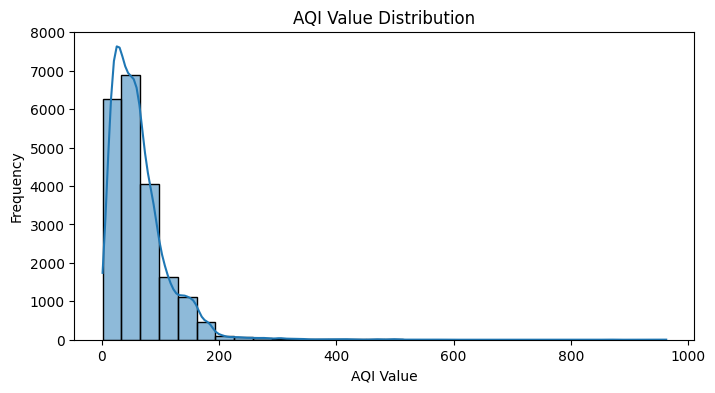

In [41]:
# EDA
print("\nSummary Statistics:\n", data.describe())

# AQI plot
plt.figure(figsize=(8, 4))
sns.histplot(data["aqi"], bins=30, kde=True)
plt.title("AQI Value Distribution")
plt.xlabel("AQI Value")
plt.ylabel("Frequency")
plt.show()

# 3. Per-Group Daily Series
> Causal forward-fill, observation mask, length checks



In [42]:
# Count observed days directly from your current data
# Assumes: data has columns: date (datetime), group, aqi, and is already AQI-filtered
obs_per_group = (
    data.dropna(subset=["date", "aqi"])
        .assign(d=lambda x: pd.to_datetime(x["date"]).dt.normalize())
        .groupby("group")["d"].nunique()
        .sort_values(ascending=False)
)

print("Top 10 groups by observed days:\n", obs_per_group.head(10))
print("\nBottom 10 groups by observed days:\n", obs_per_group.tail(10))
print("\nSummary of observed-day counts:")
print(obs_per_group.describe())

Top 10 groups by observed days:
 group
Argentina    149
Andorra      149
Armenia      149
Belgium      149
Austria      149
Australia    149
Belarus      149
Colombia     149
China        149
Chile        149
Name: d, dtype: int64

Bottom 10 groups by observed days:
 group
Zambia                      99
Cayman Islands              88
Lebanon                     86
Angola                      85
Guam                        82
Gabon                       82
Central African Republic    75
Sudan                       71
Gambia                      64
Saudi Arabia                33
Name: d, dtype: int64

Summary of observed-day counts:
count    142.000000
mean     137.239437
std       22.198949
min       33.000000
25%      137.250000
50%      149.000000
75%      149.000000
max      149.000000
Name: d, dtype: float64


In [43]:
# Helper function that builds a continuous, per-group daily time series from raw dataset rows
def make_daily_with_obs(gdf):
    gdf = gdf.dropna(subset=["date"]).sort_values("date")
    gdf["d"] = pd.to_datetime(gdf["date"]).dt.normalize()
    agg = gdf.groupby("d", as_index=True)["aqi"].mean().sort_index()

    start, end = agg.index.min(), agg.index.max()
    idx = pd.date_range(start, end, freq="D")
    ser = agg.reindex(idx)

    obs_mask = ser.notna()          # True only where an observation exists
    ser_ffill = ser.ffill()         # causal fill for modeling inputs

    df = pd.DataFrame(
        {"aqi": ser_ffill.astype(float), "obs": obs_mask.values},
        index=idx
    )
    df["date"] = df.index
    return df.reset_index(drop=True)


# keep step: use observed-day count, not span length
gblocks = []
OBS_THRESHOLD = 123  # base; per-run filtering will apply 100 or 123 as needed

# explicitly drop unwanted countries
drop_countries = {"China", "India", "United Arab Emirates", "Bangladesh"}

for g, gdf in data.groupby("group", sort=False):
    if g in drop_countries:
        continue  # skip these groups entirely

    dd = make_daily_with_obs(gdf)

    obs_days = int(dd["obs"].sum())   # number of days with a real observation
    span_days = len(dd)               # total span of days

    if obs_days >= OBS_THRESHOLD:
        dd = dd.dropna(subset=["aqi"])  # drop pre-first-observation days if any
        dd["group"] = g
        gblocks.append(dd)

if not gblocks:
    raise RuntimeError("No group had enough observed data for the configured threshold.")

data_daily = pd.concat(gblocks, ignore_index=True)
print(f"Groups kept: {data_daily['group'].nunique()} | Rows: {len(data_daily):,}")

Groups kept: 111 | Rows: 124,697


# 4. Windowing & Splits

> 60→7 sliding windows, gap filtering, calendar feats

In [44]:
# Helper function that returns the length of the longest gap (consecutive False run) in a boolean mask
def max_consec_false(mask):
    m = np.asarray(mask, dtype=bool)
    if m.size == 0: return 0
    inv = ~m
    if not inv.any(): return 0
    idx = np.where(inv)[0]
    gaps, prev, run = [], idx[0], 1
    for k in idx[1:]:
        if k == prev + 1: run += 1
        else: gaps.append(run); run = 1
        prev = k
    gaps.append(run)
    return int(max(gaps)) if gaps else 0

# PyTorch Dataset that builds sliding, causal input/output windows per group
# from a long-form daily AQI DataFrame with columns: ["group","date","aqi","obs"]
class MultiGroupWindowDataset(Dataset):
    def __init__(self, df, group2id, split="train",
                 lookback=60, pred_len=7, val_days=28, test_days=28,
                 max_consec_gap=7, use_calendar=True):
        self.samples = []
        self.group2id = group2id
        self.lookback = lookback
        self.pred_len = pred_len
        self.use_calendar = use_calendar
        self.max_consec_gap = max_consec_gap

        for g, gdf in df.groupby("group", sort=False):
            gdf = gdf.sort_values("date")
            vals = gdf["aqi"].values.astype(np.float32)
            dates= pd.to_datetime(gdf["date"]).values
            obs  = gdf["obs"].astype(bool).values
            if len(vals) < lookback + pred_len + 30: continue

            max_date = pd.to_datetime(dates[-1])
            train_end = max_date - pd.Timedelta(days=val_days + test_days)
            val_end   = max_date - pd.Timedelta(days=test_days)

            for i in range(len(vals) - (lookback + pred_len) + 1):
                start  = i
                end_in = i + lookback
                end_tg = end_in + pred_len
                anchor = pd.to_datetime(dates[end_tg - 1])
                part = "train" if anchor <= train_end else ("val" if anchor <= val_end else "test")
                if part != split: continue

                mask_window = obs[start:end_tg]
                if max_consec_false(mask_window) > self.max_consec_gap: continue

                x = vals[start:end_in]; y = vals[end_in:end_tg]
                gid = group2id[g]

                if self.use_calendar:
                    d0 = pd.to_datetime(dates[end_in])
                    dow = d0.weekday(); doy = d0.timetuple().tm_yday
                    cal = np.array([
                        np.sin(2*np.pi*dow/7.0), np.cos(2*np.pi*dow/7.0),
                        np.sin(2*np.pi*doy/365.0), np.cos(2*np.pi*doy/365.0)
                    ], dtype=np.float32)
                else:
                    cal = np.zeros(4, dtype=np.float32)

                self.samples.append({"group": g, "x": x, "y": y, "gid": gid, "cal": cal, "t0": pd.to_datetime(dates[end_in])})

        if not self.samples:
            raise RuntimeError(f"No samples for split={split}.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        s = self.samples[idx]
        x = torch.from_numpy(s["x"]).unsqueeze(-1)  # (L,1)
        y = torch.from_numpy(s["y"])                # (pred_len,)
        gid = torch.tensor(s["gid"], dtype=torch.long)
        cal = torch.from_numpy(s["cal"])
        return x, y, gid, cal

groups = sorted(data_daily["group"].unique().tolist())
group2id = {g:i for i,g in enumerate(groups)}
id2group = {i:g for g,i in group2id.items()}

train_ds = MultiGroupWindowDataset(data_daily, group2id, split="train",
                                   lookback=LOOKBACK, pred_len=PRED_LEN,
                                   val_days=VAL_DAYS, test_days=TEST_DAYS,
                                   max_consec_gap=MAX_CONSEC_GAP, use_calendar=True)
val_ds   = MultiGroupWindowDataset(data_daily, group2id, split="val",
                                   lookback=LOOKBACK, pred_len=PRED_LEN,
                                   val_days=VAL_DAYS, test_days=TEST_DAYS,
                                   max_consec_gap=MAX_CONSEC_GAP, use_calendar=True)
test_ds  = MultiGroupWindowDataset(data_daily, group2id, split="test",
                                   lookback=LOOKBACK, pred_len=PRED_LEN,
                                   val_days=VAL_DAYS, test_days=TEST_DAYS,
                                   max_consec_gap=MAX_CONSEC_GAP, use_calendar=True)

print(f" Samples to train: {len(train_ds):,} ; val: {len(val_ds):,} ; test: {len(test_ds):,}")

# Balanced sampler (reduce big-country dominance)
gc = Counter([s["gid"] for s in train_ds.samples])
weights = torch.tensor([1.0 / math.sqrt(gc[s["gid"]]) for s in train_ds.samples], dtype=torch.float)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0)


# Helper function to build data loaders for a given lookback, batch size and min_obs to be used during experiments
def build_loaders_from_daily(df_daily, lookback:int, pred_len:int, batch_size:int, min_obs:int,
                             val_days:int=VAL_DAYS, test_days:int=TEST_DAYS, max_consec_gap:int=MAX_CONSEC_GAP,
                             use_calendar:bool=True):
    
    """Filter groups by min_obs using df_daily['obs'], then construct datasets and loaders."""
    assert "group" in df_daily.columns and "obs" in df_daily.columns, "df_daily must have 'group' and 'obs' columns"

    # Filter groups
    grp_obs = df_daily.groupby("group")["obs"].sum()
    keep = set(grp_obs[grp_obs >= min_obs].index.tolist())
    df_sub = df_daily[df_daily["group"].isin(keep)].copy()
    if df_sub.empty:
        raise RuntimeError(f"No groups left after min_obs={min_obs}.")

    # Build group map
    groups = sorted(df_sub["group"].unique())
    group2id = {g:i for i,g in enumerate(groups)}

    # Datasets
    train_ds = MultiGroupWindowDataset(df_sub, group2id, split="train",
                                       lookback=lookback, pred_len=pred_len,
                                       val_days=val_days, test_days=test_days,
                                       max_consec_gap=max_consec_gap, use_calendar=use_calendar)

    val_ds   = MultiGroupWindowDataset(df_sub, group2id, split="val",
                                       lookback=lookback, pred_len=pred_len,
                                       val_days=val_days, test_days=test_days,
                                       max_consec_gap=max_consec_gap, use_calendar=use_calendar)

    test_ds  = MultiGroupWindowDataset(df_sub, group2id, split="test",
                                       lookback=lookback, pred_len=pred_len,
                                       val_days=val_days, test_days=test_days,
                                       max_consec_gap=max_consec_gap, use_calendar=use_calendar)

    # Balanced sampler for training based on above code for the single model run
    gc = Counter([s["gid"] for s in train_ds.samples])
    weights = torch.tensor([1.0 / math.sqrt(gc[s["gid"]]) for s in train_ds.samples], dtype=torch.float)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, drop_last=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

    return train_loader, val_loader, test_loader, groups, group2id, df_sub


 Samples to train: 43,610 ; val: 2,756 ; test: 2,765


# 5. Model Architecture

> Hybrid Transformer + conv, RevIN, group & calendar encoders



In [45]:
# Reversible Instance Normalization (RevIN) for time-series inputs
class RevIN(nn.Module):
    def __init__(self, d_in, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1,1,d_in))
        self.beta  = nn.Parameter(torch.zeros(1,1,d_in))
        self.eps = eps
    def forward(self, x, mode="norm", stats=None):
        if mode == "norm":
            mu  = x.mean(1, keepdim=True)
            std = x.std(1, unbiased=False, keepdim=True) + self.eps
            z = (x - mu) / std
            return z * self.gamma + self.beta, (mu, std)
        else:
            z, (mu, std) = x
            y = (z - self.beta) / (self.gamma + 1e-8)
            return y * std + mu

# Decompose an input series x (B, L, F) into additive components
# B = Batch size, L = Lookback, F = Features per time step
class MovingAvgDecomp(nn.Module):
    def __init__(self, kernel=DECOMP_K):
        super().__init__()
        pad = (kernel - 1) // 2
        self.avg = nn.AvgPool1d(kernel, stride=1, padding=pad, count_include_pad=False)
    def forward(self, x):
        trend = self.avg(x.transpose(1,2)).transpose(1,2)
        seasonal = x - trend
        return seasonal, trend

# Convert a time series (B, L, F) into a sequence of overlapping "patch" tokens
# B = Batch size, L = Lookback, F = Features per time step
class Patchify(nn.Module):
    def __init__(self, patch=PATCH, stride=STRIDE, d_model=D_MODEL):
        super().__init__()
        self.patch, self.stride = patch, stride
        self.proj = nn.Linear(patch, d_model)
    def forward(self, x):
        B,L,F = x.shape; P,S = self.patch, self.stride
        T = 1 + (L - P) // S
        xF = x.permute(0,2,1).contiguous()
        patches = xF.unfold(2, P, S)
        tokens = patches.reshape(B, F*T, P)
        return self.proj(tokens)

# Conformer-style block for time tokens
class ConformerBlock(nn.Module):
    def __init__(self, d_model=D_MODEL, n_heads=N_HEADS, d_ff=D_FF, dropout=DROPOUT, k=9):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.dw = nn.Conv1d(d_model, d_model, k, padding=k//2, groups=d_model)
        self.pw = nn.Linear(d_model, d_model)
        self.ln3 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model), nn.Dropout(dropout),
        )
    def forward(self, x):
        h = self.ln1(x); a,_ = self.attn(h,h,h, need_weights=False)
        x = x + self.drop(a)
        h = self.ln2(x).transpose(1,2)
        h = self.dw(h).transpose(1,2)
        x = x + self.pw(h)
        x = x + self.ffn(self.ln3(x))
        return x

# Low-pass filter over the token sequence along the time dimension using FFT
class FourierLowpass(nn.Module):
    def __init__(self, keep_ratio=0.25):
        super().__init__()
        self.keep = keep_ratio
    def forward(self, x):
        B,T,D = x.shape
        X = torch.fft.rfft(x, dim=1)
        k = max(1, int(X.size(1)*self.keep))
        X_low = torch.zeros_like(X); X_low[:, :k] = X[:, :k]
        return torch.fft.irfft(X_low, n=T, dim=1)

# End-to-end hybrid forecaster for our AQI project
class AQIHybridLite(nn.Module):
    """
    Seasonal encoder (MHSA + depthwise conv) + Trend TCN + gated fusion.
    Head learns normalized corrections; mix gate blends Last vs Last-Week base.
    """
    def __init__(self, n_features, pred_len=PRED_LEN,
                 d_model=D_MODEL, n_heads=N_HEADS, layers=LAYERS, d_ff=D_FF,
                 patch=PATCH, stride=STRIDE, decomp_k=DECOMP_K, dropout=DROPOUT,
                 use_revin=USE_REVIN, use_fourier=USE_FOURIER, pos_cap=POS_CAP,
                 num_groups=1, use_group_emb=USE_GROUP_EMB, use_calendar=USE_CALENDAR):
        super().__init__()
        self.use_revin = use_revin; self.use_fourier = use_fourier
        self.use_group_emb = use_group_emb; self.use_calendar = use_calendar

        self.revin = RevIN(n_features) if use_revin else None
        self.decomp = MovingAvgDecomp(decomp_k)
        self.patch = Patchify(patch, stride, d_model)
        self.pos = nn.Parameter(torch.randn(1, POS_CAP, d_model) * 0.01)
        self.blocks = nn.ModuleList([ConformerBlock(d_model, n_heads, d_ff, dropout) for _ in range(layers)])
        self.fourier = FourierLowpass(0.25) if use_fourier else None
        self.norm = nn.LayerNorm(d_model)
        self.trend_tcn = nn.Sequential(
            nn.Conv1d(n_features, d_model//2, 5, padding=2), nn.ReLU(),
            nn.Conv1d(d_model//2, d_model, 5, padding=2),
            nn.AdaptiveAvgPool1d(1)
        )
        self.gate = nn.Linear(2*d_model, d_model)

        self.head = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model, pred_len))
        self.mix_gate = nn.Linear(d_model, pred_len)

        if use_group_emb: self.group_emb = nn.Embedding(num_groups, d_model)
        else: self.group_emb = None
        if use_calendar: self.cal_proj = nn.Sequential(nn.Linear(4, d_model), nn.GELU())
        else: self.cal_proj = None

    def forward(self, x, gid=None, calfeat=None):
        stats = None
        if self.use_revin: x, stats = self.revin(x, mode="norm")
        seasonal, trend = self.decomp(x)

        tok = self.patch(seasonal)
        T = tok.size(1); tok = tok + self.pos[:, :T]
        for blk in self.blocks: tok = blk(tok)
        if self.use_fourier: tok = tok + self.fourier(tok)
        z_seasonal = self.norm(tok).mean(1)

        z_trend = self.trend_tcn(trend.transpose(1,2)).squeeze(-1)
        g = torch.sigmoid(self.gate(torch.cat([z_seasonal, z_trend], -1)))
        z = g*z_seasonal + (1-g)*z_trend

        if self.group_emb is not None and gid is not None: z = z + self.group_emb(gid)
        if self.cal_proj  is not None and calfeat is not None: z = z + self.cal_proj(calfeat)

        delta_norm = self.head(z)               # normalized corrections
        alpha = torch.sigmoid(self.mix_gate(z)) # blend Last vs Last-Week
        return delta_norm, stats, alpha

# Run the model and return denormalized y_pred plus Δ in absolute units
@torch.no_grad()
def hybrid_predict_denorm(model, x, gid=None, cal=None):
    model.eval()
    return _hybrid_forward_with_denorm(model, x, gid, cal)

# Compose the final forecast in the original AQI scale
def _hybrid_forward_with_denorm(model, x, gid=None, cal=None):
    delta_norm, stats, alpha = model(x, gid=gid, calfeat=cal)
    if stats is not None:
        mu, std = stats
        std = std[:, :, 0].squeeze(1)
        gamma = model.revin.gamma[0, 0, 0]
        delta_abs = delta_norm * (std.unsqueeze(1) / (gamma + 1e-8))
    else:
        delta_abs = delta_norm

    pred_len = delta_abs.size(1)
    last_val  = x[:, -1, 0].unsqueeze(1).repeat(1, pred_len)
    last_week = x[:, -pred_len:, 0]
    base = alpha * last_val + (1.0 - alpha) * last_week
    y_pred = torch.clamp(base + delta_abs, min=AQI_MIN, max=AQI_MAX)
    return y_pred, delta_abs

# 6. Training Helpers

> Loops, metrics, baselines, early stop, LR scheduler


In [46]:
# Compute scalar regression metrics from tensor predictions
def metrics_from_tensors(y_true, y_pred):
    yt = y_true.reshape(-1).detach().cpu().numpy().astype(np.float64)
    yp = y_pred.reshape(-1).detach().cpu().numpy().astype(np.float64)
    err = yp - yt
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    ss_res = float(np.sum(err**2))
    ss_tot = float(np.sum((yt - float(np.mean(yt)))**2)) + 1e-12
    r2 = 1.0 - ss_res/ss_tot
    return mae, rmse, r2

# Evaluate the model over a DataLoader
@torch.no_grad()
def evaluate(model, loader, return_preds=False):
    model.eval()
    all_y, all_p = [], []
    for xb, yb, gid, cal in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        gid = gid.to(DEVICE); cal = cal.to(DEVICE)
        yp_den, _ = _hybrid_forward_with_denorm(model, xb, gid, cal)
        all_y.append(yb); all_p.append(yp_den)
    y_true = torch.cat(all_y, dim=0)
    y_pred = torch.cat(all_p, dim=0)
    if return_preds:
        return metrics_from_tensors(y_true, y_pred), (y_true, y_pred)
    return metrics_from_tensors(y_true, y_pred)

# Evaluate baselines on the same loader
@torch.no_grad()
def evaluate_baselines(loader, pred_len=PRED_LEN):
    y_all, last_all, week_all = [], [], []
    for xb, yb, _, _ in loader:
        B,L,F = xb.shape
        last_val = xb[:, -1, 0].unsqueeze(1).repeat(1, pred_len)
        last_week= xb[:, L - pred_len:, 0]
        y_all.append(yb); last_all.append(last_val); week_all.append(last_week)
    y = torch.cat(y_all); p_last = torch.cat(last_all); p_week = torch.cat(week_all)
    return metrics_from_tensors(y, p_last), metrics_from_tensors(y, p_week)

criterion = nn.SmoothL1Loss(beta=5.0, reduction="none")
HW = torch.tensor(HORIZ_WEIGHTS).view(1, -1).to(DEVICE)
 
# Helper function to find robust "recent slope" that fits any lookback length L
def last_k_slope(xb, k=7):
    """
    xb: input window, shape [B, L, F]
    Returns |x_t - x_{t-k}| as a column vector [B, 1], capping k to L-1.
    """
    # if window is too short, return zeros
    L = xb.size(1)
    if L < 2:
        return torch.zeros((xb.size(0), 1), device=xb.device, dtype=xb.dtype)

    k = min(k, L - 1)  # use 7 days if possible, else longest valid gap
    return (xb[:, -1, 0] - xb[:, -(k + 1), 0]).abs().unsqueeze(1)

# Training function for one epoch
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss, count = 0.0, 0
    for xb, yb, gid, cal in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        gid = gid.to(DEVICE); cal = cal.to(DEVICE)

        # Slope over last 7d → emphasize steep regimes
        slope = last_k_slope(xb, k=7)
        err_w = (1.0 + ERR_SLOPE_LMB * (slope / 50.0)).clamp(1.0, 3.0)
        pen_scale = 1.0 / (1.0 + SLOPE_K * slope)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(scaler is not None and scaler.is_enabled())):
            y_pred, delta_abs = _hybrid_forward_with_denorm(model, xb, gid, cal)
            main = criterion(y_pred, yb).mean(dim=0, keepdim=True)
            main = (main * HW).mean()
            main = (err_w.mean() * main)
            reg  = (CORR_L2 * (pen_scale * (delta_abs ** 2))).mean()
            loss = main + reg

        if scaler is not None and scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()

        bs = xb.size(0)
        total_loss += float(loss.item()) * bs
        count += bs

    return total_loss / max(1, count)


In [47]:
# Loss function for multi-step forecasts
# Same objective as training: SmoothL1 + λ‖Δ‖²
def seq_loss_smoothl1_delta(y_hat, y_true, lam=None, beta=None):
    """
    y_hat, y_true: [B, H] or [N, H] tensors (float)
    lam: smoothness weight (falls back to your global if present)
    beta: SmoothL1 beta (Huber threshold)
    """
    lam = (lam if lam is not None else
           globals().get('DELTA_LAMBDA',
           globals().get('LAMBDA_DELTA',
           globals().get('LAMBDA_SMOOTH',
           globals().get('DELTA_PENALTY', 0.0)))))
    beta = (beta if beta is not None else
            globals().get('HUBER_BETA',
            globals().get('SMOOTHL1_BETA', 1.0)))

    data_term = F.smooth_l1_loss(y_hat, y_true, beta=beta, reduction='mean')
    diffs = y_hat[:, 1:] - y_hat[:, :-1]  # day-to-day deltas across horizons
    smooth_term = (diffs ** 2).mean()
    return data_term + lam * smooth_term

# 7. Model Training

> Instantiate, run epochs, checkpoint best



[Info] Starting training …
Epoch 01 | train (SmoothL1+λ‖Δ‖²): 12.68342 | val LOSS: 8.10058  MAE: 8.505  RMSE: 17.946  R²: 0.827  | lr=3.00e-04
Epoch 02 | train (SmoothL1+λ‖Δ‖²): 11.48555 | val LOSS: 8.06883  MAE: 8.477  RMSE: 17.778  R²: 0.830  | lr=3.00e-04
Epoch 03 | train (SmoothL1+λ‖Δ‖²): 11.14684 | val LOSS: 8.04778  MAE: 8.439  RMSE: 17.847  R²: 0.829  | lr=3.00e-04
Epoch 04 | train (SmoothL1+λ‖Δ‖²): 10.87447 | val LOSS: 7.94712  MAE: 8.347  RMSE: 17.349  R²: 0.839  | lr=3.00e-04
Epoch 05 | train (SmoothL1+λ‖Δ‖²): 10.63402 | val LOSS: 7.97071  MAE: 8.365  RMSE: 17.359  R²: 0.838  | lr=3.00e-04
Epoch 06 | train (SmoothL1+λ‖Δ‖²): 10.55597 | val LOSS: 8.03337  MAE: 8.425  RMSE: 17.622  R²: 0.833  | lr=3.00e-04
Epoch 07 | train (SmoothL1+λ‖Δ‖²): 10.16599 | val LOSS: 8.10835  MAE: 8.508  RMSE: 17.674  R²: 0.832  | lr=1.50e-04 (↓ from 3.00e-04)
Epoch 08 | train (SmoothL1+λ‖Δ‖²): 10.01847 | val LOSS: 8.08568  MAE: 8.478  RMSE: 17.600  R²: 0.834  | lr=1.50e-04
Epoch 09 | train (SmoothL1+

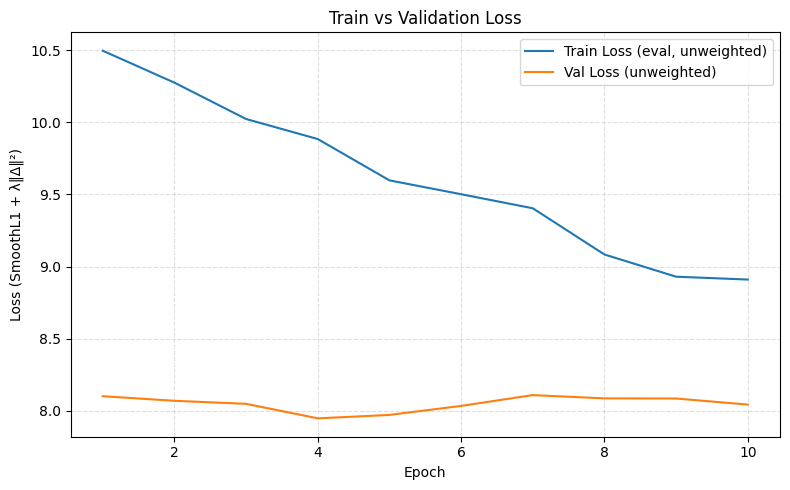

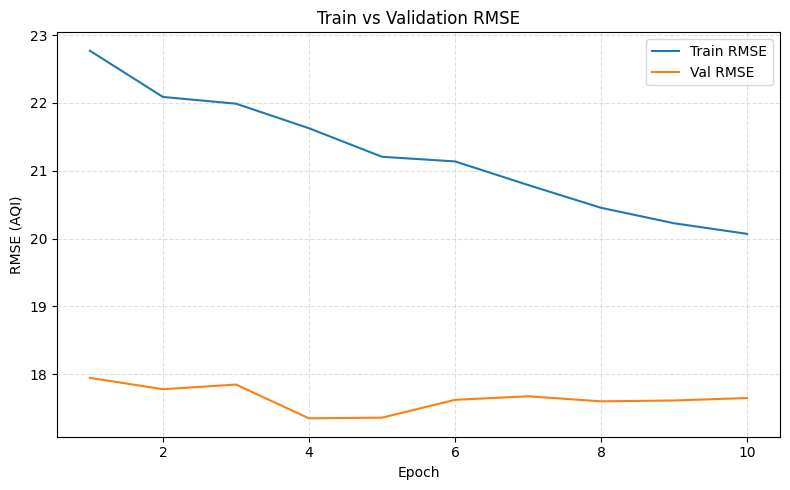

In [48]:
# Model Training (original + history + plot)
model = AQIHybridLite(
    n_features=1, pred_len=PRED_LEN, d_model=D_MODEL, n_heads=N_HEADS, layers=LAYERS, d_ff=D_FF,
    patch=PATCH, stride=STRIDE, decomp_k=DECOMP_K, dropout=DROPOUT,
    use_revin=USE_REVIN, use_fourier=USE_FOURIER, pos_cap=POS_CAP,
    num_groups=len(groups), use_group_emb=USE_GROUP_EMB, use_calendar=USE_CALENDAR
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=FACTOR, patience=2, min_lr=MIN_LR
)

# AMP setup (safe if CPU too)
use_amp = (DEVICE.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

train_eval_loader = DataLoader(
    train_loader.dataset,           # reuse same dataset as training
    batch_size=BATCH_SIZE,          # same batch size is fine
    shuffle=False,                  # important: deterministic order
    num_workers=getattr(train_loader, "num_workers", 0),
    pin_memory=getattr(train_loader, "pin_memory", False),
    drop_last=False
)

print("[Info] Starting training …")

# Training state
best_rmse = math.inf
best_state = None
best_epoch = None
epochs_no_improve = 0
save_path = os.path.join(OUTDIR, "model_best.pt")

history = {
    "epoch": [],
    "train_loss": [],
    "train_mae": [],
    "train_rmse": [],
    "train_r2": [],
    "val_loss": [],
    "val_mae": [],
    "val_rmse": [],
    "val_r2": [],
    "lr": [],
}

# Training loop
for epoch in range(1, EPOCHS + 1):
    # one training epoch (returns SmoothL1 + λ‖Δ‖² mean over batches)
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
    (_, _, _), (y_tr_eval, yhat_tr_eval) = evaluate(model, train_eval_loader, return_preds=True)
    train_eval_loss = seq_loss_smoothl1_delta(yhat_tr_eval.to(DEVICE), y_tr_eval.to(DEVICE)).item()

    # validation metrics + preds so we can compute the SAME loss on val
    (val_mae, val_rmse, val_r2), (y_val, yhat_val) = evaluate(model, val_loader, return_preds=True)
    train_mae, train_rmse, train_r2 = evaluate(model, train_eval_loader, return_preds=False)

    # compute validation loss (SmoothL1 + λ‖Δ‖²) on the validation preds/targets
    y_val_t    = torch.as_tensor(y_val,    device=DEVICE, dtype=torch.float32)
    yhat_val_t = torch.as_tensor(yhat_val, device=DEVICE, dtype=torch.float32)
    val_loss = seq_loss_smoothl1_delta(yhat_val_t, y_val_t).item()

    # scheduler on validation RMSE (the metric we report/monitor)
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_rmse)
    new_lr = optimizer.param_groups[0]['lr']

    print(
        f"Epoch {epoch:02d} | train (SmoothL1+λ‖Δ‖²): {train_loss:.5f} | "
        f"val LOSS: {val_loss:.5f}  MAE: {val_mae:.3f}  RMSE: {val_rmse:.3f}  R²: {val_r2:.3f}  | "
        f"lr={new_lr:.2e}" + (f" (↓ from {prev_lr:.2e})" if new_lr < prev_lr else "")
    )

    # log history
    history["epoch"].append(epoch)
    history["train_loss"].append(float(train_loss))
    history.setdefault("train_eval_loss", []).append(float(train_eval_loss))
    history["train_mae"].append(float(train_mae))
    history["train_rmse"].append(float(train_rmse))
    history["train_r2"].append(float(train_r2))
    history["val_loss"].append(float(val_loss))
    history["val_mae"].append(float(val_mae))
    history["val_rmse"].append(float(val_rmse))
    history["val_r2"].append(float(val_r2))
    history["lr"].append(float(new_lr))

    # best-by-RMSE checkpointing + early stopping
    if val_rmse + 1e-6 < best_rmse:
        best_rmse = float(val_rmse)
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        os.makedirs(OUTDIR, exist_ok=True)
        torch.save(best_state, save_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"[Info] Early stopping at epoch {epoch}. Best RMSE={best_rmse:.3f} (epoch {best_epoch})")
            break

# Restore best model (by val RMSE)
if (best_state is None) and os.path.exists(save_path):
    best_state = torch.load(save_path, map_location="cpu")

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"[Info] Loaded best val model (RMSE={best_rmse:.3f}, epoch {best_epoch}) from {save_path}.")

# Persist training history
os.makedirs(OUTDIR, exist_ok=True)
hist_path = os.path.join(OUTDIR, "training_history.csv")
pd.DataFrame(history).to_csv(hist_path, index=False)
print(f"[Info] Saved training history → {hist_path}")

# Plot 1: Train vs Val Loss
plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["train_eval_loss"], label="Train Loss (eval, unweighted)")
plt.plot(history["epoch"], history["val_loss"],        label="Val Loss (unweighted)")
plt.xlabel("Epoch"); plt.ylabel("Loss (SmoothL1 + λ‖Δ‖²)")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

plot1 = os.path.join(OUTDIR, "train_vs_val_loss.png")
plt.savefig(plot1, dpi=140)
plt.show()

# Plot 2: Train Loss vs Val RMSE
plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["train_rmse"], label="Train RMSE")
plt.plot(history["epoch"], history["val_rmse"],   label="Val RMSE")
plt.xlabel("Epoch"); plt.ylabel("RMSE (AQI)")
plt.title("Train vs Validation RMSE")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

plot2 = os.path.join(OUTDIR, "train_vs_val_rmse.png")
plt.savefig(plot2, dpi=140)
plt.show()

# 8. Evaluation & Report

> Test metrics and evaluation plots



[TEST] (bs=96, lb=60) Model  ->  MAE: 8.673 | RMSE: 17.638 | R^2: 0.813
[BASELINE] (bs=96, lb=60) Last   ->  MAE: 9.640 | RMSE: 20.365 | R^2: 0.751
[BASELINE] (bs=96, lb=60) Week   ->  MAE: 16.575 | RMSE: 26.835 | R^2: 0.567


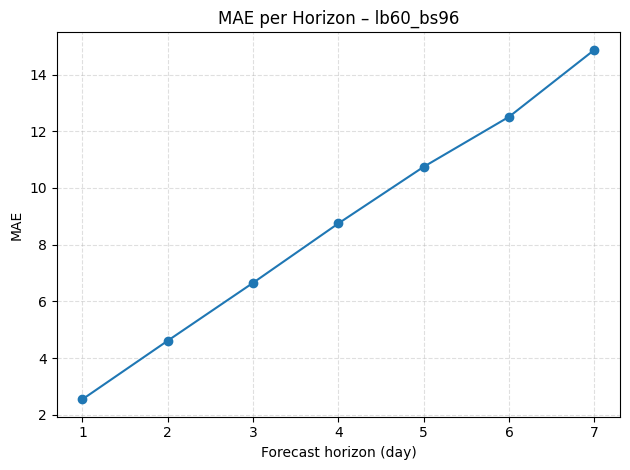

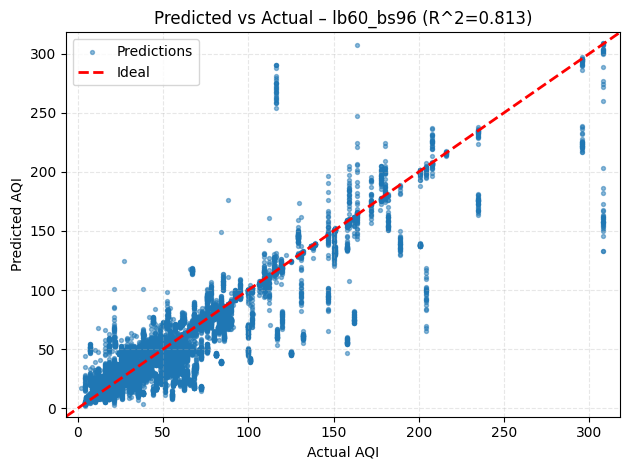

In [49]:
# Test metrics 
(test_mae, test_rmse, test_r2), (y_true, y_pred) = evaluate(model, test_loader, return_preds=True)
print(
    f"[TEST] (bs={BATCH_SIZE}, lb={LOOKBACK}) Model  ->  "
    f"MAE: {test_mae:.3f} | RMSE: {test_rmse:.3f} | R^2: {test_r2:.3f}"
)

# Baseline metrics 
(last_mae, last_rmse, last_r2), (wk_mae, wk_rmse, wk_r2) = evaluate_baselines(test_loader)
print(
    f"[BASELINE] (bs={BATCH_SIZE}, lb={LOOKBACK}) Last   ->  "
    f"MAE: {last_mae:.3f} | RMSE: {last_rmse:.3f} | R^2: {last_r2:.3f}"
)
print(
    f"[BASELINE] (bs={BATCH_SIZE}, lb={LOOKBACK}) Week   ->  "
    f"MAE: {wk_mae:.3f} | RMSE: {wk_rmse:.3f} | R^2: {wk_r2:.3f}"
)

# Safely convert from torch tensors to NumPy
def to_np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

yt = to_np(y_true)   # shape [N, H]
yp = to_np(y_pred)   # shape [N, H]

H = yt.shape[1]
mae_per_h = np.mean(np.abs(yp - yt), axis=0)

y_true_flat = yt.ravel()
y_pred_flat = yp.ravel()
r2_flat = r2_score(y_true_flat, y_pred_flat)

os.makedirs(OUTDIR, exist_ok=True)
tag = f"lb{LOOKBACK}_bs{BATCH_SIZE}"

# Error over horizon plot
plt.figure()
plt.plot(np.arange(1, H+1), mae_per_h, marker='o')
plt.xlabel("Forecast horizon (day)"); plt.ylabel("MAE")
plt.title(f"MAE per Horizon – {tag}")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

plot3 = os.path.join(OUTDIR, f"error_over_horizon_{tag}.png")
plt.savefig(plot3, dpi=140)
plt.show()

# Predicted vs Actual plot
plt.figure()
plt.scatter(y_true_flat, y_pred_flat, s=8, alpha=0.5, label="Predictions")

# Ideal y = x line
minv = float(min(y_true_flat.min(), y_pred_flat.min()))
maxv = float(max(y_true_flat.max(), y_pred_flat.max()))
pad = 0.03 * (maxv - minv)            # small margin so the line isn't on the frame
lo, hi = minv - pad, maxv + pad

plt.plot([lo, hi], [lo, hi], color="red", linestyle="--", linewidth=2, label="Ideal")

plt.xlim(lo, hi); plt.ylim(lo, hi)

plt.xlabel("Actual AQI"); plt.ylabel("Predicted AQI")
plt.title(f"Predicted vs Actual – {tag} (R^2={r2_flat:.3f})")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

plot4 = os.path.join(OUTDIR, f"pred_vs_actual_{tag}.png")
plt.savefig(plot4, dpi=140)
plt.show()



# 9. Experiments

> Batch Size and Lookback Experiments



In [50]:
# Training function for batch size and lookback experiments
def run_training_experiment(lookback: int, batch_size: int, epochs: int = EPOCHS):
    """
    Train one (lookback, batch_size) config with early stopping.
    Prints bs/lb in logs and produces plots.
    Returns (result_dict, history_dict).
    """

    # Configuration for the run 
    global LOOKBACK, BATCH_SIZE, model
    LOOKBACK = int(lookback)
    BATCH_SIZE = int(batch_size)
    min_obs = get_obs_threshold(LOOKBACK)

    # Data loaders
    train_loader, val_loader, test_loader, groups, group2id, df_sub = build_loaders_from_daily(
        data_daily, lookback=LOOKBACK, pred_len=PRED_LEN, batch_size=BATCH_SIZE, min_obs=min_obs
    )

    # Fresh model for each configuration
    model = AQIHybridLite(
        n_features=1, pred_len=PRED_LEN, d_model=D_MODEL, n_heads=N_HEADS, layers=LAYERS, d_ff=D_FF,
        patch=PATCH, stride=STRIDE, decomp_k=DECOMP_K, dropout=DROPOUT,
        use_revin=USE_REVIN, use_fourier=USE_FOURIER, pos_cap=POS_CAP,
        num_groups=len(groups), use_group_emb=USE_GROUP_EMB, use_calendar=USE_CALENDAR
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=FACTOR, patience=2, min_lr=MIN_LR
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

    train_eval_loader = DataLoader(
    train_loader.dataset,           # reuse same dataset as training
    batch_size=BATCH_SIZE,          # same batch size is fine
    shuffle=False,                  # important: deterministic order
    num_workers=getattr(train_loader, "num_workers", 0),
    pin_memory=getattr(train_loader, "pin_memory", False),
    drop_last=False
    )

    # Early stopping trackers
    best_rmse, best_epoch = float("inf"), -1
    patience_es = 6
    min_delta = 0.002
    no_improve = 0
    lr_reductions = 0
    best_state = None

    # History storage
    history = {
    "epoch": [],
    "train_loss": [],
    "train_mae": [],
    "train_rmse": [],
    "train_r2": [],
    "val_loss": [],
    "val_mae": [],
    "val_rmse": [],
    "val_r2": [],
    "lr": [],
}

    steps_per_epoch = len(train_loader)
    print(f"[plan] (bs={BATCH_SIZE}, lb={LOOKBACK}) steps/epoch={steps_per_epoch}, epochs={epochs}")
    print(f"\n=== Training start (bs={BATCH_SIZE}, lb={LOOKBACK}, min_obs={min_obs}) ===")

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, scaler)

        (_, _, _), (y_tr_eval, yhat_tr_eval) = evaluate(model, train_eval_loader, return_preds=True)
        train_eval_loss = seq_loss_smoothl1_delta(yhat_tr_eval.to(DEVICE), y_tr_eval.to(DEVICE)).item()

        # validation metrics + preds so we can compute the SAME loss on val
        (val_mae, val_rmse, val_r2), (y_val, yhat_val) = evaluate(model, val_loader, return_preds=True)
        train_mae, train_rmse, train_r2 = evaluate(model, train_eval_loader, return_preds=False)

        # compute validation loss (SmoothL1 + λ‖Δ‖²) on the validation preds/targets
        y_val_t    = torch.as_tensor(y_val,    device=DEVICE, dtype=torch.float32)
        yhat_val_t = torch.as_tensor(yhat_val, device=DEVICE, dtype=torch.float32)
        val_loss = seq_loss_smoothl1_delta(yhat_val_t, y_val_t).item()

        prev_lr = float(optimizer.param_groups[0]["lr"])
        scheduler.step(val_rmse)
        new_lr = float(optimizer.param_groups[0]["lr"])

        msg = (
            f"[bs={BATCH_SIZE} lb={LOOKBACK}] Epoch {epoch:02d} | "
            f"train (SmoothL1 + lambda*||delta||^2): {train_loss:.5f} | "
            f"val Loss: {val_loss:.5f} val MAE: {val_mae:.3f}  RMSE: {val_rmse:.3f}  R^2: {val_r2:.3f} | "
            f"lr={new_lr:.2e}"
        )
        if new_lr < prev_lr:
            msg += f" (down from {prev_lr:.2e})"
        print(msg)

        # Log
        history["epoch"].append(epoch)
        history["train_loss"].append(float(train_loss))
        history.setdefault("train_eval_loss", []).append(float(train_eval_loss))
        history["train_mae"].append(float(train_mae))
        history["train_rmse"].append(float(train_rmse))
        history["train_r2"].append(float(train_r2))
        history["val_loss"].append(float(val_loss))
        history["val_mae"].append(float(val_mae))
        history["val_rmse"].append(float(val_rmse))
        history["val_r2"].append(float(val_r2))
        history["lr"].append(float(new_lr))

        # Early stopping bookkeeping
        if new_lr < prev_lr:
            lr_reductions += 1

        if val_rmse < best_rmse - min_delta:
            best_rmse, best_epoch = float(val_rmse), epoch
            best_state = deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1

        if (
            no_improve >= patience_es
            or (lr_reductions >= 2 and no_improve >= 3)
            or (new_lr <= MIN_LR and no_improve >= 3)
        ):
            print(
                f"[early stop] (bs={BATCH_SIZE}, lb={LOOKBACK}) at epoch {epoch} | "
                f"best @ {best_epoch} (val RMSE={best_rmse:.3f})"
            )
            break

    # Restore best before evaluating on test set
    if best_state is not None:
        model.load_state_dict(best_state)

    # Evaluation
    (test_mae, test_rmse, test_r2), (y_true, y_pred) = evaluate(model, test_loader, return_preds=True)
    (last_mae, last_rmse, last_r2), (wk_mae, wk_rmse, wk_r2) = evaluate_baselines(test_loader)

    print(
        f"[TEST] (bs={BATCH_SIZE}, lb={LOOKBACK}) Model  ->  "
        f"MAE: {test_mae:.3f} | RMSE: {test_rmse:.3f} | R^2: {test_r2:.3f}"
    )
    print(
        f"[BASELINE] (bs={BATCH_SIZE}, lb={LOOKBACK}) Last   ->  "
        f"MAE: {last_mae:.3f} | RMSE: {last_rmse:.3f} | R^2: {last_r2:.3f}"
    )
    print(
        f"[BASELINE] (bs={BATCH_SIZE}, lb={LOOKBACK}) Week   ->  "
        f"MAE: {wk_mae:.3f} | RMSE: {wk_rmse:.3f} | R^2: {wk_r2:.3f}"
    )

    # Create descriptive plots

    # Safely convert from torch tensors to NumPy
    def to_np(x):
        return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

    yt = to_np(y_true)   # shape [N, H]
    yp = to_np(y_pred)   # shape [N, H]

    H = yt.shape[1]
    mae_per_h = np.mean(np.abs(yp - yt), axis=0)

    y_true_flat = yt.ravel()
    y_pred_flat = yp.ravel()
    r2_flat = r2_score(y_true_flat, y_pred_flat)

    os.makedirs(OUTDIR, exist_ok=True)
    tag = f"lb{LOOKBACK}_bs{BATCH_SIZE}"

    # Train vs Val Loss plot
    plt.figure(figsize=(8,5))
    plt.plot(history["epoch"], history["train_eval_loss"], label="Train Loss (eval, unweighted)")
    plt.plot(history["epoch"], history["val_loss"],        label="Val Loss (unweighted)")
    plt.xlabel("Epoch"); plt.ylabel("Loss (SmoothL1 + λ‖Δ‖²)")
    plt.title("Train vs Validation Loss")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    loss_path = os.path.join(OUTDIR, f"trainloss_vs_valloss_lb{LOOKBACK}_bs{BATCH_SIZE}.png")
    plt.savefig(loss_path, dpi=140)
    plt.show()
    print(f"[saved] {loss_path}")

    # Train Loss vs Val RMSE plot
    plt.figure(figsize=(8,5))
    plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
    plt.plot(history["epoch"], history["val_rmse"], label="Val RMSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss / RMSE")
    plt.title(f"Train Loss vs Val RMSE — lb{LOOKBACK} bs{BATCH_SIZE}")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    tl_path = os.path.join(OUTDIR, f"trainloss_vs_valrmse_lb{LOOKBACK}_bs{BATCH_SIZE}.png")
    plt.savefig(tl_path, dpi=140)
    plt.show()
    print(f"[saved] {tl_path}")

    # Error over horizon plot
    plt.figure()
    plt.plot(np.arange(1, H+1), mae_per_h, marker='o')
    plt.xlabel("Forecast horizon (day)"); plt.ylabel("MAE")
    plt.title(f"MAE per Horizon – {tag}")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    path1 = os.path.join(OUTDIR, f"error_over_horizon_{tag}.png")
    plt.savefig(path1, dpi=140)
    plt.show()

    # Predicted vs Actual plot
    plt.figure()
    plt.scatter(y_true_flat, y_pred_flat, s=8, alpha=0.5, label="Predictions")

    # Ideal y = x line
    minv = float(min(y_true_flat.min(), y_pred_flat.min()))
    maxv = float(max(y_true_flat.max(), y_pred_flat.max()))
    pad = 0.03 * (maxv - minv)            # small margin so the line isn't on the frame
    lo, hi = minv - pad, maxv + pad

    plt.plot([lo, hi], [lo, hi], color="red", linestyle="--", linewidth=2, label="Ideal")

    plt.xlim(lo, hi); plt.ylim(lo, hi)

    plt.xlabel("Actual AQI"); plt.ylabel("Predicted AQI")
    plt.title(f"Predicted vs Actual – {tag} (R^2={r2_flat:.3f})")
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()

    path2 = os.path.join(OUTDIR, f"pred_vs_actual_{tag}.png")
    plt.savefig(path2, dpi=140)
    plt.show()

    print(f"[saved] {path1}")
    print(f"[saved] {path2}")


    # Return the results
    return {
        "lookback": LOOKBACK, "batch_size": BATCH_SIZE, "min_obs": min_obs,
        "val_best_rmse": best_rmse, "val_best_epoch": best_epoch,
        "test_mae": test_mae, "test_rmse": test_rmse, "test_r2": test_r2,
        "last_mae": last_mae, "last_rmse": last_rmse, "last_r2": last_r2,
        "week_mae": wk_mae, "week_rmse": wk_rmse, "week_r2": wk_r2,
    }, history



[plan] (bs=32, lb=7) steps/epoch=1946, epochs=40

=== Training start (bs=32, lb=7, min_obs=100) ===
[bs=32 lb=7] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.09778 | val Loss: 8.39340 val MAE: 8.767  RMSE: 18.532  R^2: 0.809 | lr=3.00e-04
[bs=32 lb=7] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.93405 | val Loss: 8.30382 val MAE: 8.655  RMSE: 18.455  R^2: 0.811 | lr=3.00e-04
[bs=32 lb=7] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.85239 | val Loss: 8.34986 val MAE: 8.700  RMSE: 18.508  R^2: 0.810 | lr=3.00e-04
[bs=32 lb=7] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 11.73060 | val Loss: 8.32569 val MAE: 8.673  RMSE: 18.534  R^2: 0.809 | lr=3.00e-04
[bs=32 lb=7] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 11.73351 | val Loss: 8.32969 val MAE: 8.676  RMSE: 18.521  R^2: 0.810 | lr=1.50e-04 (down from 3.00e-04)
[bs=32 lb=7] Epoch 06 | train (SmoothL1 + lambda*||delta||^2): 11.54473 | val Loss: 8.38233 val MAE: 8.725  RMSE: 18.550  R^2: 0.809 | lr=1.50e-

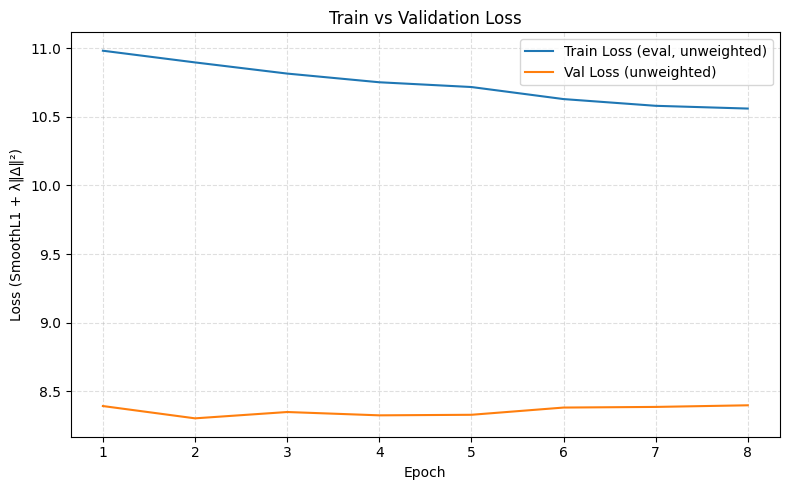

[saved] ./aqi_outputs\trainloss_vs_valloss_lb7_bs32.png


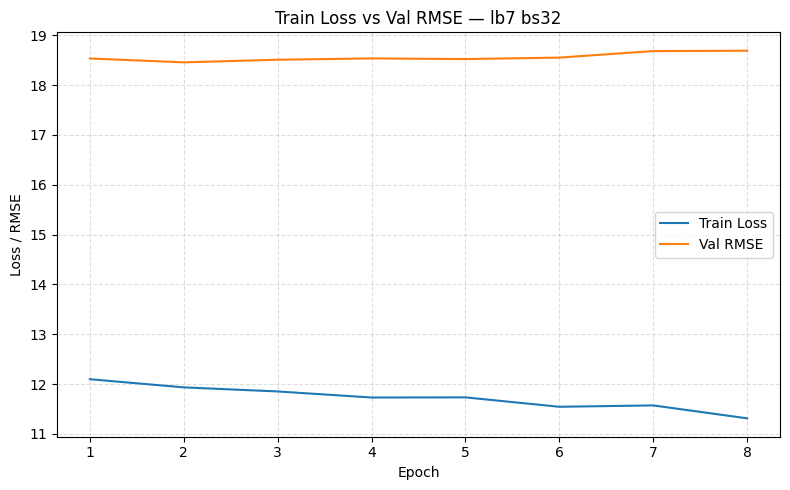

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb7_bs32.png


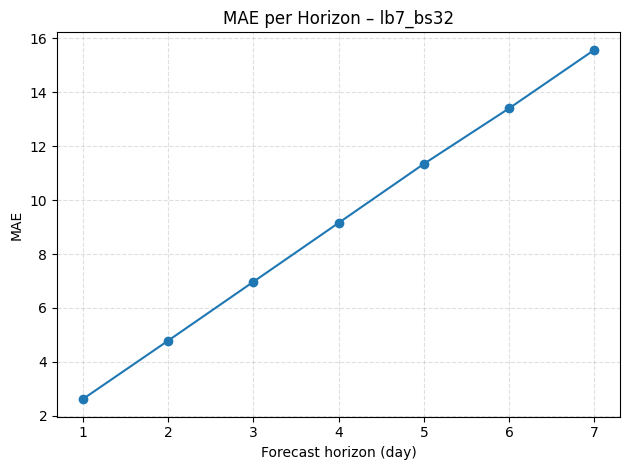

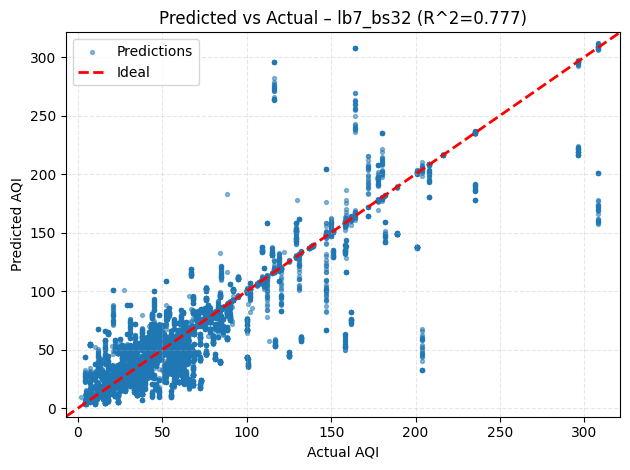

[saved] ./aqi_outputs\error_over_horizon_lb7_bs32.png
[saved] ./aqi_outputs\pred_vs_actual_lb7_bs32.png
[plan] (bs=64, lb=7) steps/epoch=973, epochs=40

=== Training start (bs=64, lb=7, min_obs=100) ===
[bs=64 lb=7] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.21899 | val Loss: 8.40087 val MAE: 8.767  RMSE: 18.575  R^2: 0.809 | lr=3.00e-04
[bs=64 lb=7] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.91754 | val Loss: 8.37049 val MAE: 8.725  RMSE: 18.555  R^2: 0.809 | lr=3.00e-04
[bs=64 lb=7] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.73209 | val Loss: 8.31852 val MAE: 8.669  RMSE: 18.474  R^2: 0.811 | lr=3.00e-04
[bs=64 lb=7] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 11.91184 | val Loss: 8.32253 val MAE: 8.665  RMSE: 18.516  R^2: 0.810 | lr=3.00e-04
[bs=64 lb=7] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 11.80629 | val Loss: 8.36634 val MAE: 8.710  RMSE: 18.611  R^2: 0.808 | lr=3.00e-04
[bs=64 lb=7] Epoch 06 | train (SmoothL1 + lambda*||delta||^2):

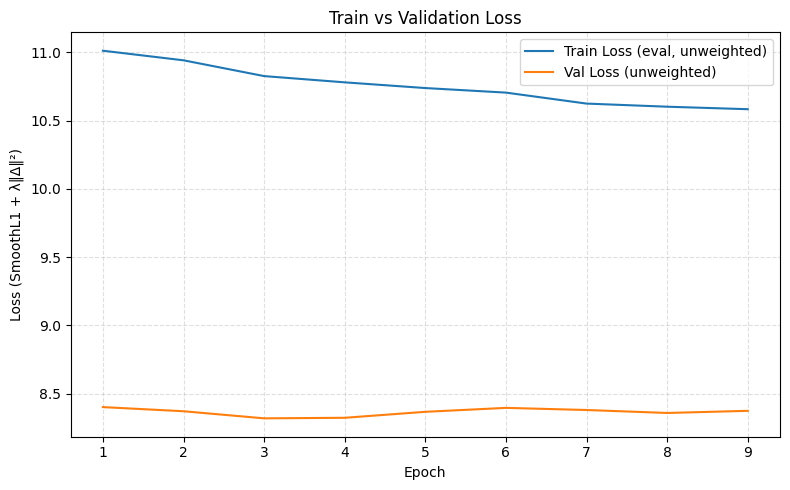

[saved] ./aqi_outputs\trainloss_vs_valloss_lb7_bs64.png


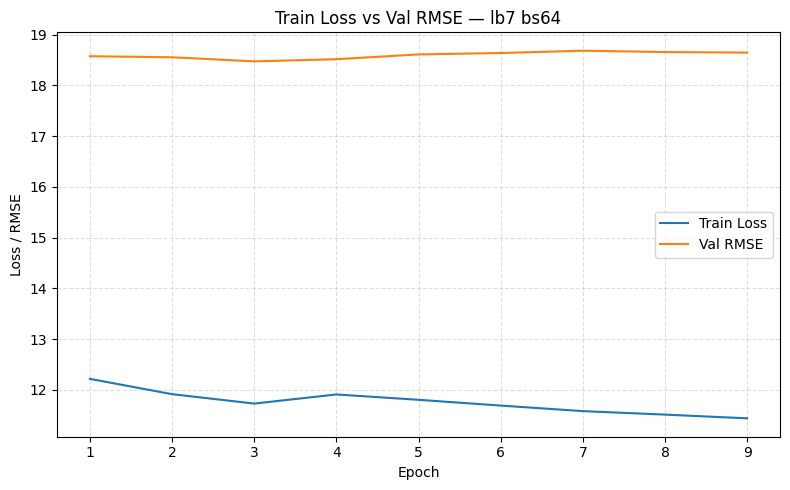

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb7_bs64.png


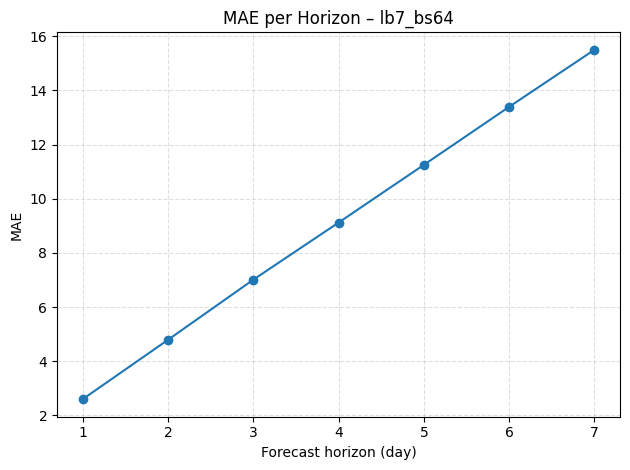

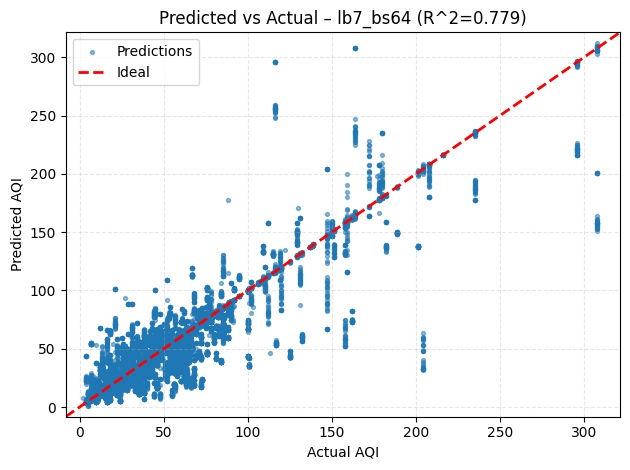

[saved] ./aqi_outputs\error_over_horizon_lb7_bs64.png
[saved] ./aqi_outputs\pred_vs_actual_lb7_bs64.png
[plan] (bs=96, lb=7) steps/epoch=648, epochs=40

=== Training start (bs=96, lb=7, min_obs=100) ===
[bs=96 lb=7] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.17357 | val Loss: 8.35594 val MAE: 8.728  RMSE: 18.448  R^2: 0.811 | lr=3.00e-04
[bs=96 lb=7] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.77750 | val Loss: 8.27203 val MAE: 8.628  RMSE: 18.428  R^2: 0.812 | lr=3.00e-04
[bs=96 lb=7] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.89463 | val Loss: 8.34133 val MAE: 8.694  RMSE: 18.545  R^2: 0.809 | lr=3.00e-04
[bs=96 lb=7] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 11.75075 | val Loss: 8.34467 val MAE: 8.704  RMSE: 18.515  R^2: 0.810 | lr=3.00e-04
[bs=96 lb=7] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 11.74511 | val Loss: 8.35428 val MAE: 8.712  RMSE: 18.512  R^2: 0.810 | lr=1.50e-04 (down from 3.00e-04)
[bs=96 lb=7] Epoch 06 | train (SmoothL1 +

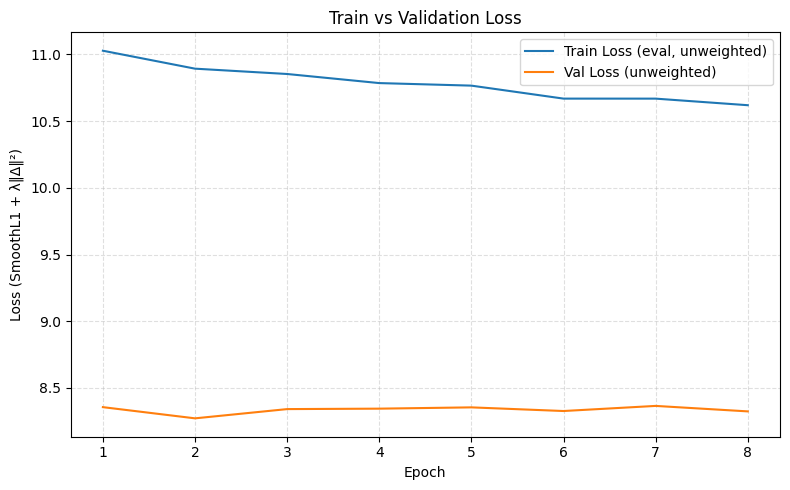

[saved] ./aqi_outputs\trainloss_vs_valloss_lb7_bs96.png


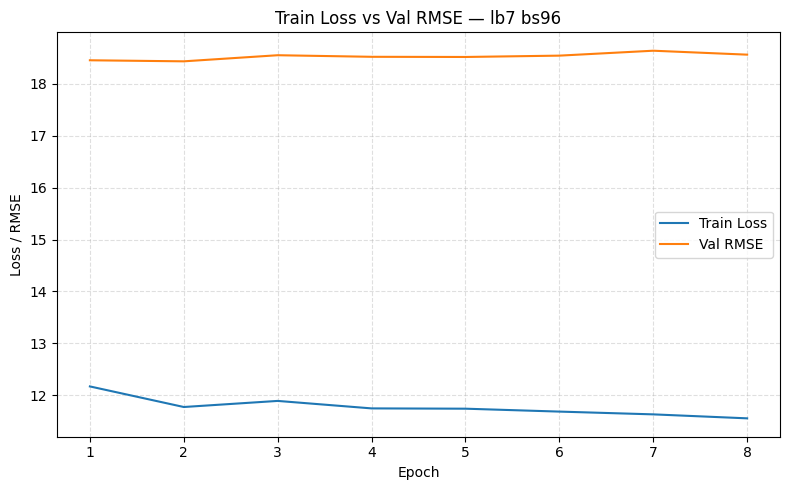

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb7_bs96.png


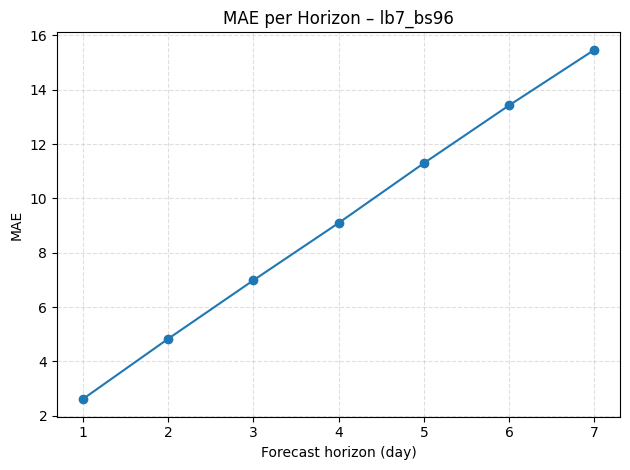

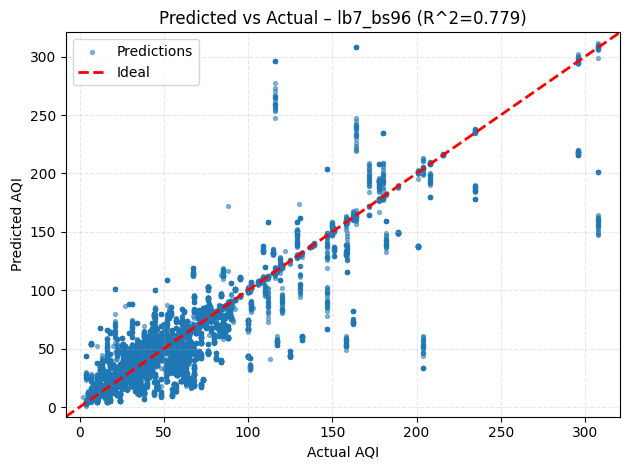

[saved] ./aqi_outputs\error_over_horizon_lb7_bs96.png
[saved] ./aqi_outputs\pred_vs_actual_lb7_bs96.png
[plan] (bs=128, lb=7) steps/epoch=486, epochs=40

=== Training start (bs=128, lb=7, min_obs=100) ===
[bs=128 lb=7] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.37194 | val Loss: 8.29817 val MAE: 8.674  RMSE: 18.338  R^2: 0.813 | lr=3.00e-04
[bs=128 lb=7] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.92366 | val Loss: 8.31754 val MAE: 8.676  RMSE: 18.423  R^2: 0.812 | lr=3.00e-04
[bs=128 lb=7] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.93023 | val Loss: 8.34723 val MAE: 8.711  RMSE: 18.386  R^2: 0.812 | lr=3.00e-04
[bs=128 lb=7] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 11.78288 | val Loss: 8.33878 val MAE: 8.695  RMSE: 18.483  R^2: 0.810 | lr=1.50e-04 (down from 3.00e-04)
[bs=128 lb=7] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 11.70835 | val Loss: 8.31965 val MAE: 8.663  RMSE: 18.424  R^2: 0.812 | lr=1.50e-04
[bs=128 lb=7] Epoch 06 | train (Sm

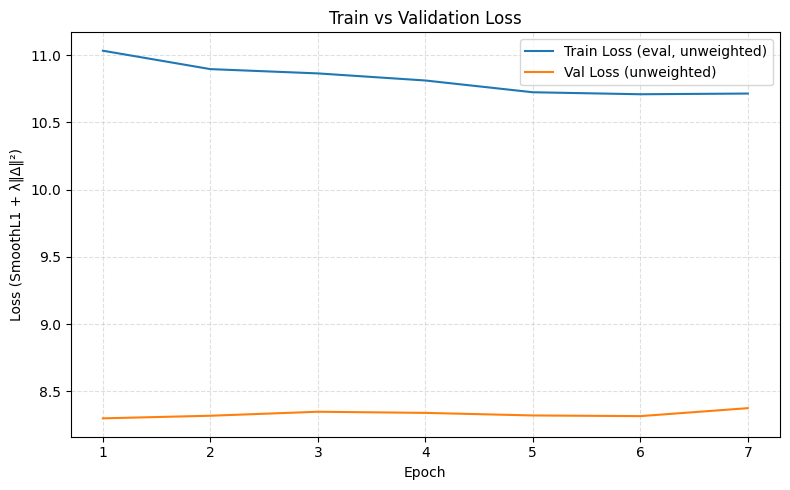

[saved] ./aqi_outputs\trainloss_vs_valloss_lb7_bs128.png


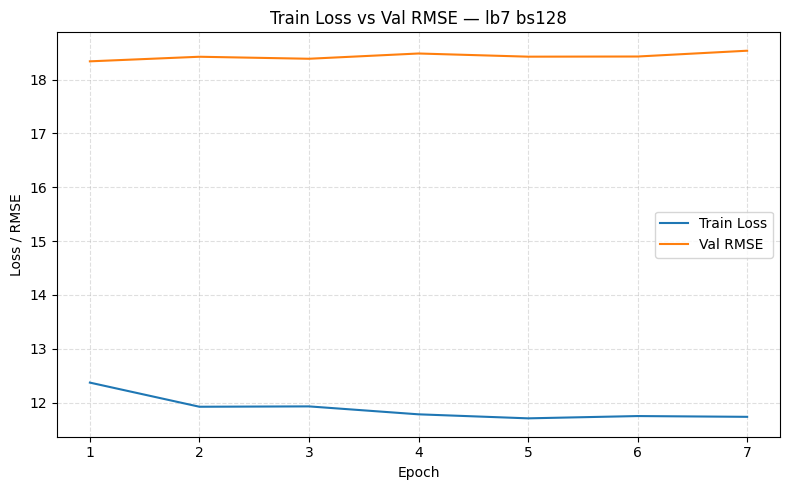

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb7_bs128.png


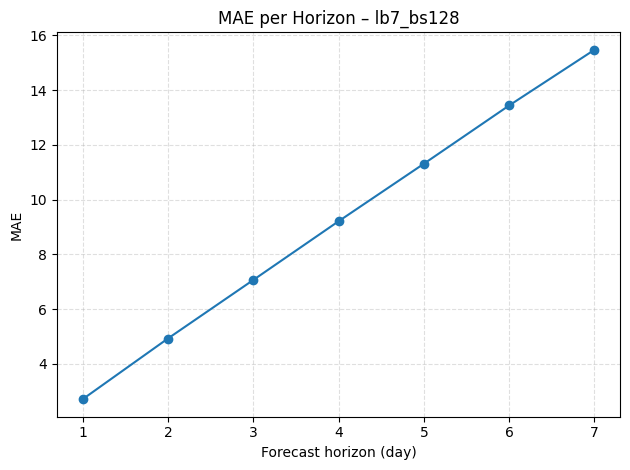

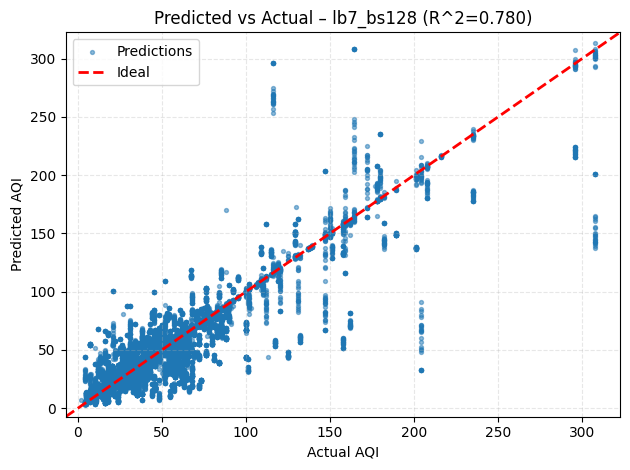

[saved] ./aqi_outputs\error_over_horizon_lb7_bs128.png
[saved] ./aqi_outputs\pred_vs_actual_lb7_bs128.png
[plan] (bs=32, lb=30) steps/epoch=1685, epochs=40

=== Training start (bs=32, lb=30, min_obs=123) ===
[bs=32 lb=30] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 11.96824 | val Loss: 8.00686 val MAE: 8.405  RMSE: 17.794  R^2: 0.829 | lr=3.00e-04
[bs=32 lb=30] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.38054 | val Loss: 8.11015 val MAE: 8.504  RMSE: 17.989  R^2: 0.825 | lr=3.00e-04
[bs=32 lb=30] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 10.96792 | val Loss: 8.06789 val MAE: 8.459  RMSE: 18.039  R^2: 0.824 | lr=3.00e-04
[bs=32 lb=30] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.64664 | val Loss: 8.11843 val MAE: 8.505  RMSE: 18.223  R^2: 0.821 | lr=1.50e-04 (down from 3.00e-04)
[bs=32 lb=30] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.26478 | val Loss: 8.33930 val MAE: 8.733  RMSE: 19.177  R^2: 0.802 | lr=1.50e-04
[bs=32 lb=30] Epoch 06 | train 

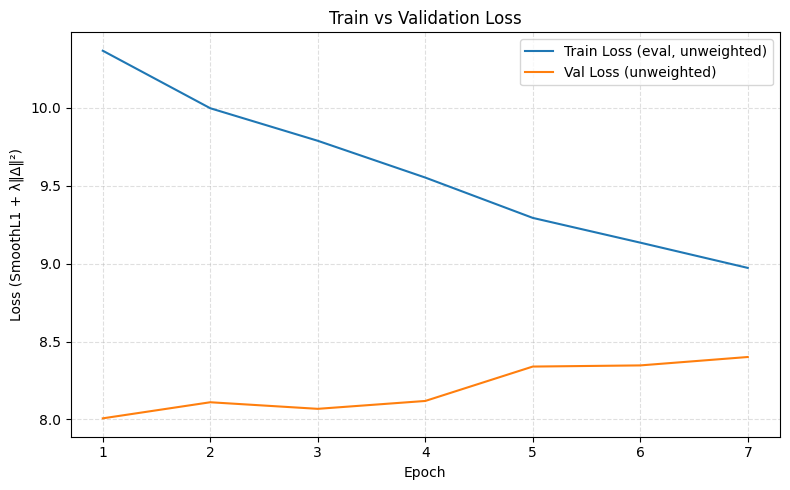

[saved] ./aqi_outputs\trainloss_vs_valloss_lb30_bs32.png


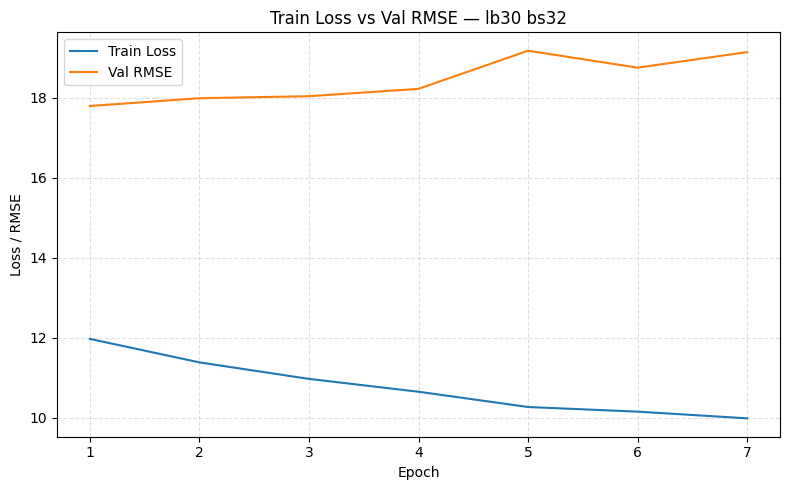

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb30_bs32.png


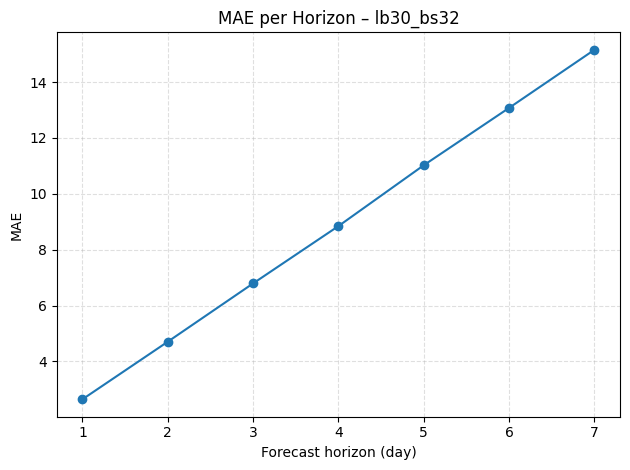

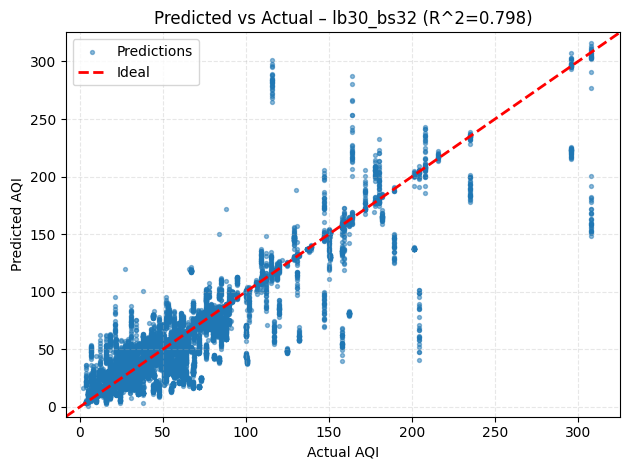

[saved] ./aqi_outputs\error_over_horizon_lb30_bs32.png
[saved] ./aqi_outputs\pred_vs_actual_lb30_bs32.png
[plan] (bs=64, lb=30) steps/epoch=842, epochs=40

=== Training start (bs=64, lb=30, min_obs=123) ===
[bs=64 lb=30] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 11.97509 | val Loss: 8.29770 val MAE: 8.711  RMSE: 17.952  R^2: 0.826 | lr=3.00e-04
[bs=64 lb=30] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.35848 | val Loss: 7.98673 val MAE: 8.386  RMSE: 17.637  R^2: 0.832 | lr=3.00e-04
[bs=64 lb=30] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.03398 | val Loss: 8.03352 val MAE: 8.426  RMSE: 17.905  R^2: 0.827 | lr=3.00e-04
[bs=64 lb=30] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.70388 | val Loss: 8.21650 val MAE: 8.610  RMSE: 18.096  R^2: 0.823 | lr=3.00e-04
[bs=64 lb=30] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.48149 | val Loss: 8.19219 val MAE: 8.585  RMSE: 17.961  R^2: 0.826 | lr=1.50e-04 (down from 3.00e-04)
[bs=64 lb=30] Epoch 06 | train (

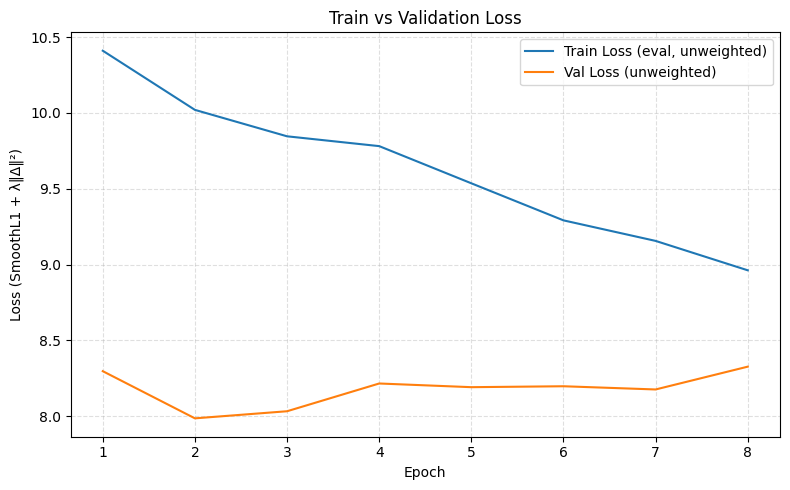

[saved] ./aqi_outputs\trainloss_vs_valloss_lb30_bs64.png


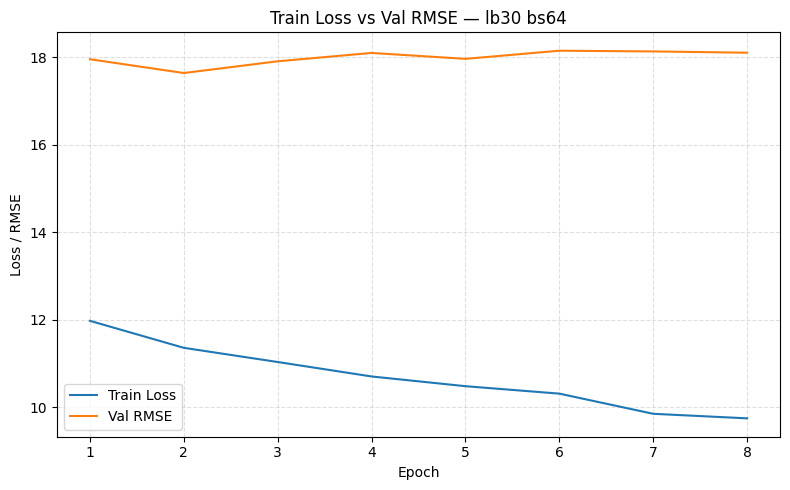

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb30_bs64.png


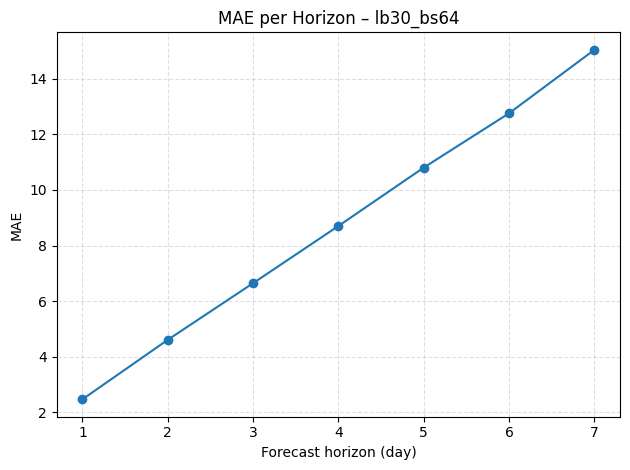

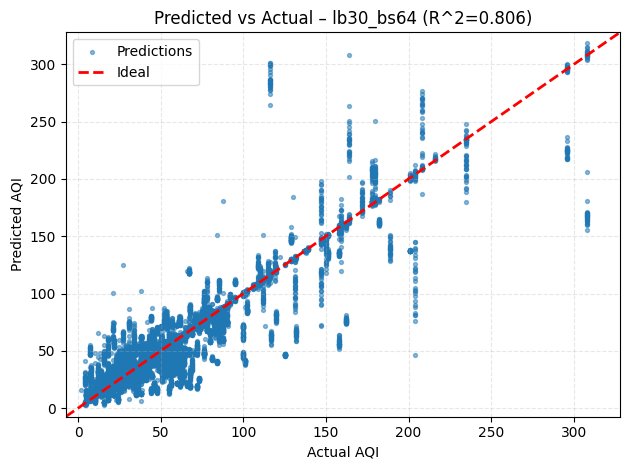

[saved] ./aqi_outputs\error_over_horizon_lb30_bs64.png
[saved] ./aqi_outputs\pred_vs_actual_lb30_bs64.png
[plan] (bs=96, lb=30) steps/epoch=561, epochs=40

=== Training start (bs=96, lb=30, min_obs=123) ===
[bs=96 lb=30] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.21635 | val Loss: 8.10458 val MAE: 8.522  RMSE: 17.756  R^2: 0.830 | lr=3.00e-04
[bs=96 lb=30] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.22051 | val Loss: 7.98829 val MAE: 8.394  RMSE: 17.756  R^2: 0.830 | lr=3.00e-04
[bs=96 lb=30] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.04566 | val Loss: 7.94981 val MAE: 8.342  RMSE: 17.566  R^2: 0.834 | lr=3.00e-04
[bs=96 lb=30] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.67460 | val Loss: 7.95725 val MAE: 8.345  RMSE: 17.719  R^2: 0.831 | lr=3.00e-04
[bs=96 lb=30] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.51788 | val Loss: 8.13550 val MAE: 8.523  RMSE: 18.318  R^2: 0.819 | lr=3.00e-04
[bs=96 lb=30] Epoch 06 | train (SmoothL1 + lambda*||d

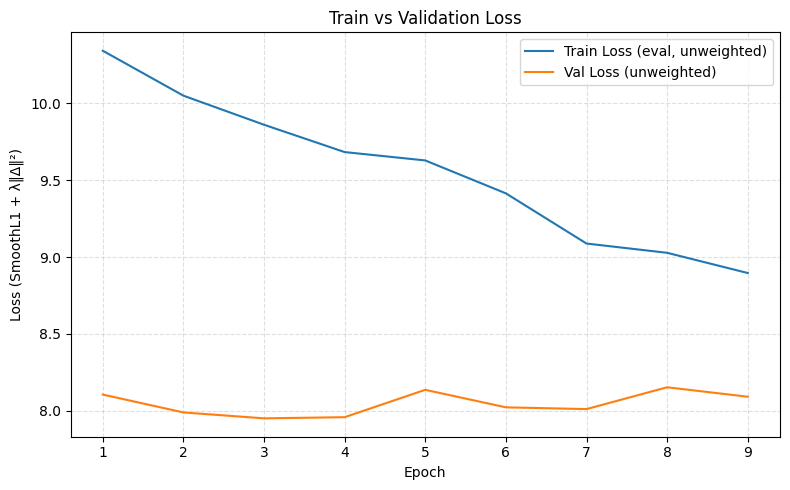

[saved] ./aqi_outputs\trainloss_vs_valloss_lb30_bs96.png


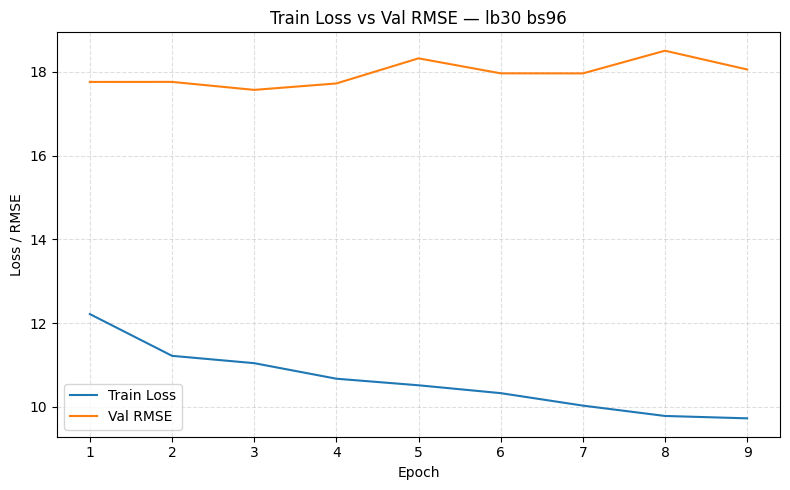

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb30_bs96.png


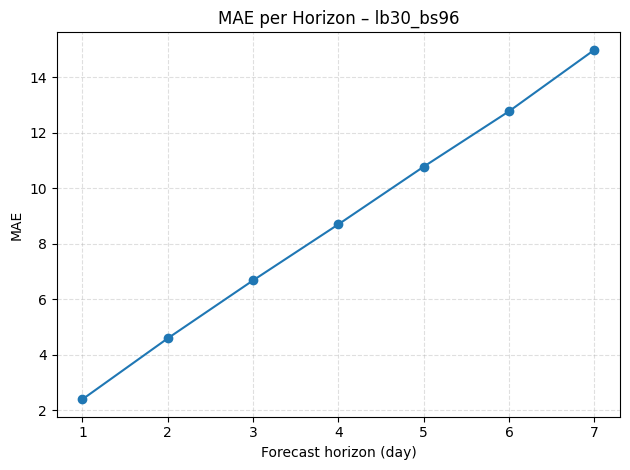

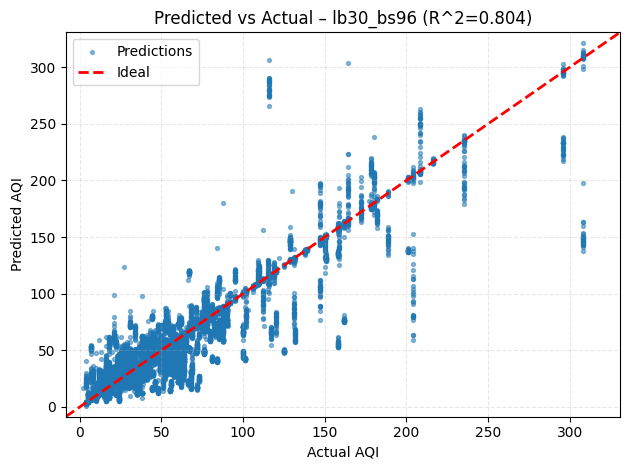

[saved] ./aqi_outputs\error_over_horizon_lb30_bs96.png
[saved] ./aqi_outputs\pred_vs_actual_lb30_bs96.png
[plan] (bs=128, lb=30) steps/epoch=421, epochs=40

=== Training start (bs=128, lb=30, min_obs=123) ===
[bs=128 lb=30] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.01811 | val Loss: 8.15648 val MAE: 8.568  RMSE: 17.939  R^2: 0.826 | lr=3.00e-04
[bs=128 lb=30] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.12152 | val Loss: 7.98262 val MAE: 8.378  RMSE: 17.701  R^2: 0.831 | lr=3.00e-04
[bs=128 lb=30] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.05699 | val Loss: 7.93944 val MAE: 8.333  RMSE: 17.752  R^2: 0.830 | lr=3.00e-04
[bs=128 lb=30] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.62667 | val Loss: 8.03688 val MAE: 8.437  RMSE: 17.876  R^2: 0.828 | lr=3.00e-04
[bs=128 lb=30] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.59634 | val Loss: 7.96335 val MAE: 8.351  RMSE: 17.748  R^2: 0.830 | lr=1.50e-04 (down from 3.00e-04)
[bs=128 lb=30] Epoch 06 |

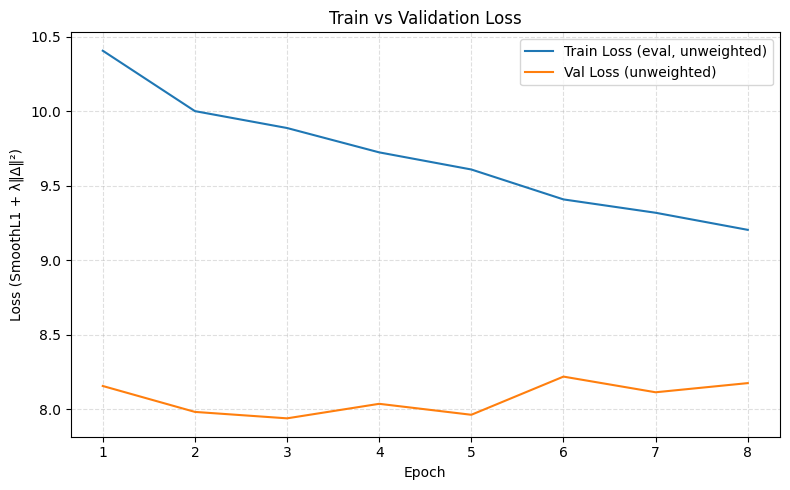

[saved] ./aqi_outputs\trainloss_vs_valloss_lb30_bs128.png


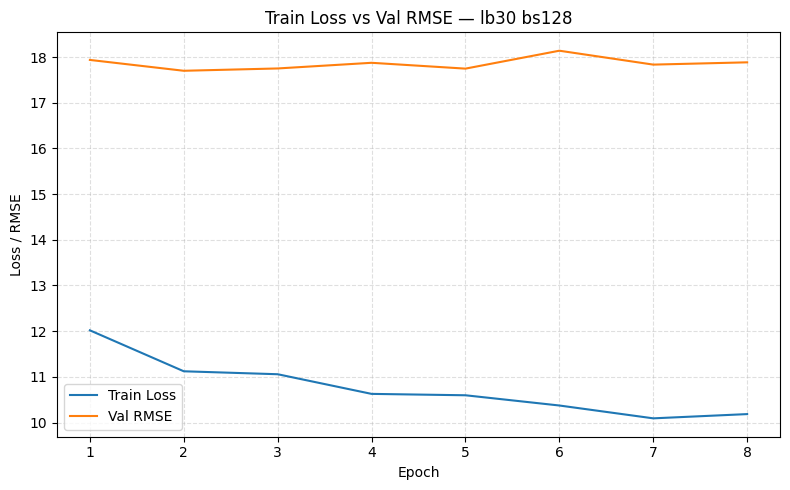

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb30_bs128.png


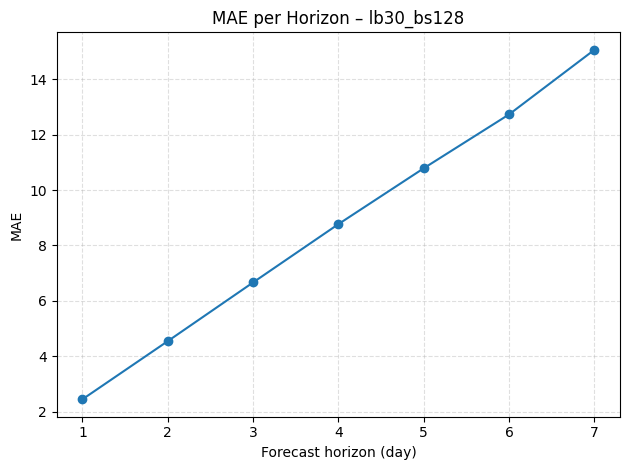

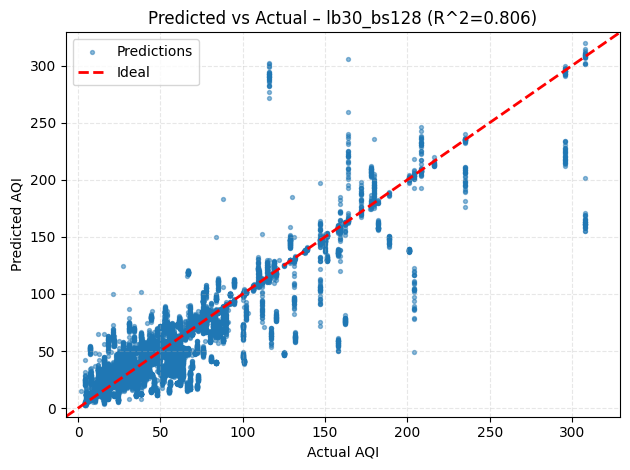

[saved] ./aqi_outputs\error_over_horizon_lb30_bs128.png
[saved] ./aqi_outputs\pred_vs_actual_lb30_bs128.png
[plan] (bs=32, lb=60) steps/epoch=1362, epochs=40

=== Training start (bs=32, lb=60, min_obs=123) ===
[bs=32 lb=60] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.77293 | val Loss: 8.22175 val MAE: 8.625  RMSE: 18.103  R^2: 0.824 | lr=3.00e-04
[bs=32 lb=60] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.53685 | val Loss: 8.00770 val MAE: 8.394  RMSE: 17.697  R^2: 0.832 | lr=3.00e-04
[bs=32 lb=60] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.03895 | val Loss: 7.90807 val MAE: 8.291  RMSE: 17.620  R^2: 0.833 | lr=3.00e-04
[bs=32 lb=60] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.81799 | val Loss: 8.00180 val MAE: 8.389  RMSE: 17.910  R^2: 0.828 | lr=3.00e-04
[bs=32 lb=60] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.45333 | val Loss: 8.24220 val MAE: 8.637  RMSE: 17.949  R^2: 0.827 | lr=3.00e-04
[bs=32 lb=60] Epoch 06 | train (SmoothL1 + lambda*

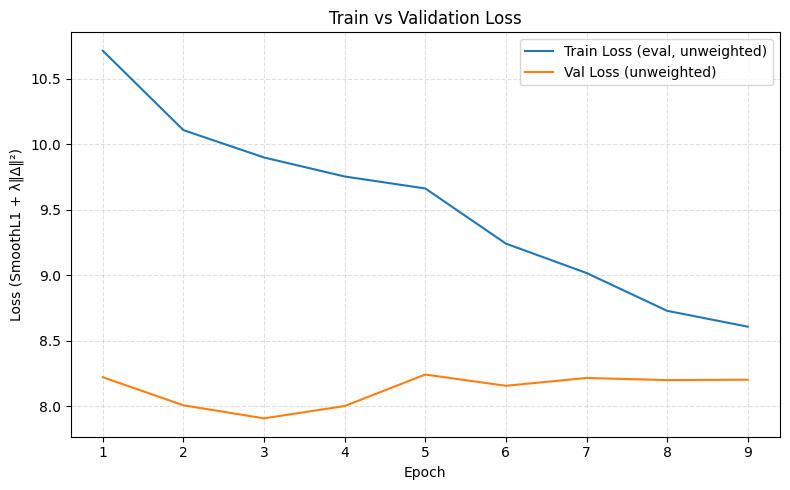

[saved] ./aqi_outputs\trainloss_vs_valloss_lb60_bs32.png


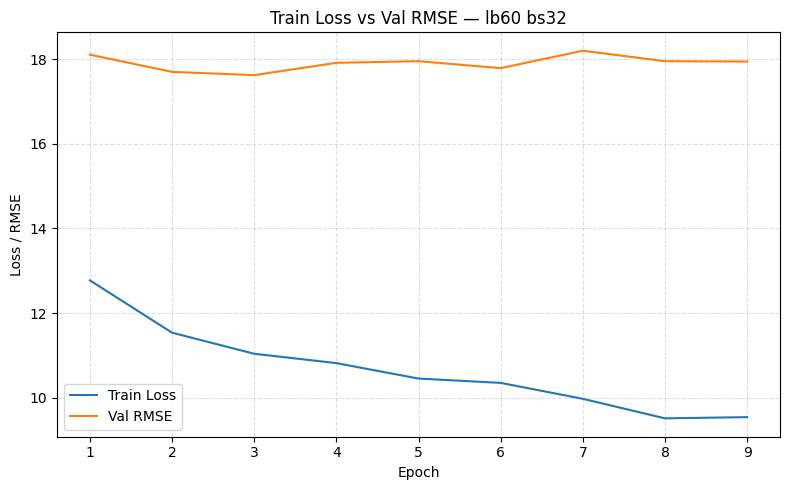

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb60_bs32.png


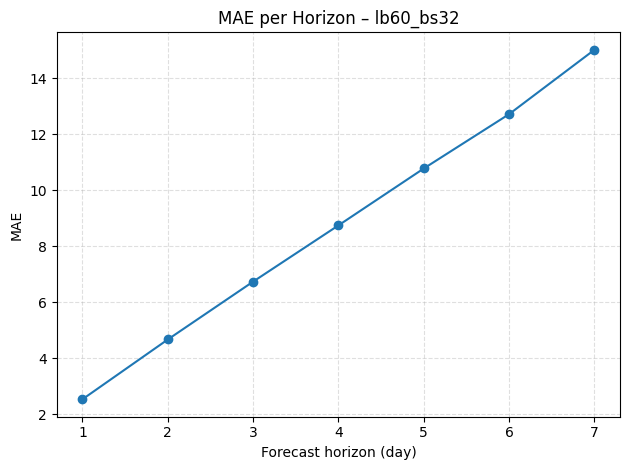

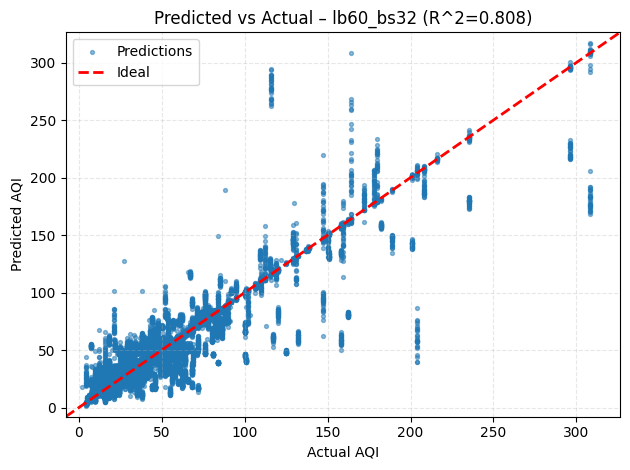

[saved] ./aqi_outputs\error_over_horizon_lb60_bs32.png
[saved] ./aqi_outputs\pred_vs_actual_lb60_bs32.png
[plan] (bs=64, lb=60) steps/epoch=681, epochs=40

=== Training start (bs=64, lb=60, min_obs=123) ===
[bs=64 lb=60] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.77711 | val Loss: 8.10782 val MAE: 8.506  RMSE: 17.824  R^2: 0.830 | lr=3.00e-04
[bs=64 lb=60] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.24531 | val Loss: 8.02467 val MAE: 8.412  RMSE: 17.696  R^2: 0.832 | lr=3.00e-04
[bs=64 lb=60] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 10.98631 | val Loss: 8.14901 val MAE: 8.546  RMSE: 17.927  R^2: 0.828 | lr=3.00e-04
[bs=64 lb=60] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.90972 | val Loss: 7.92114 val MAE: 8.304  RMSE: 17.494  R^2: 0.836 | lr=3.00e-04
[bs=64 lb=60] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.60551 | val Loss: 8.07091 val MAE: 8.458  RMSE: 17.847  R^2: 0.829 | lr=3.00e-04
[bs=64 lb=60] Epoch 06 | train (SmoothL1 + lambda*||d

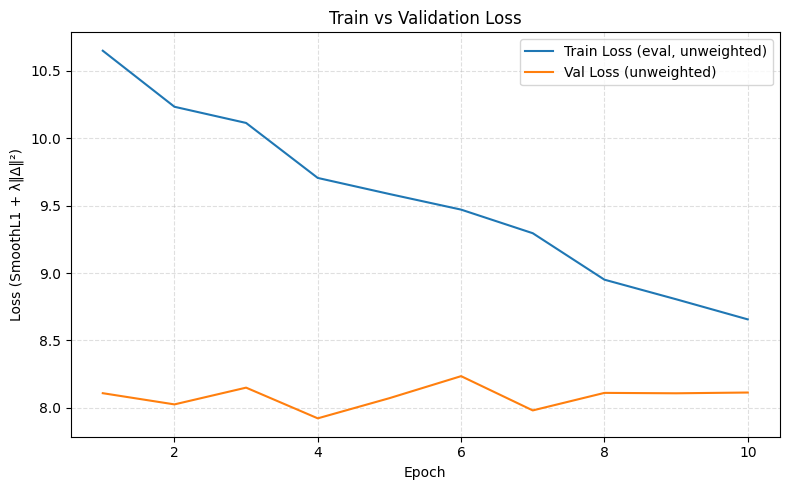

[saved] ./aqi_outputs\trainloss_vs_valloss_lb60_bs64.png


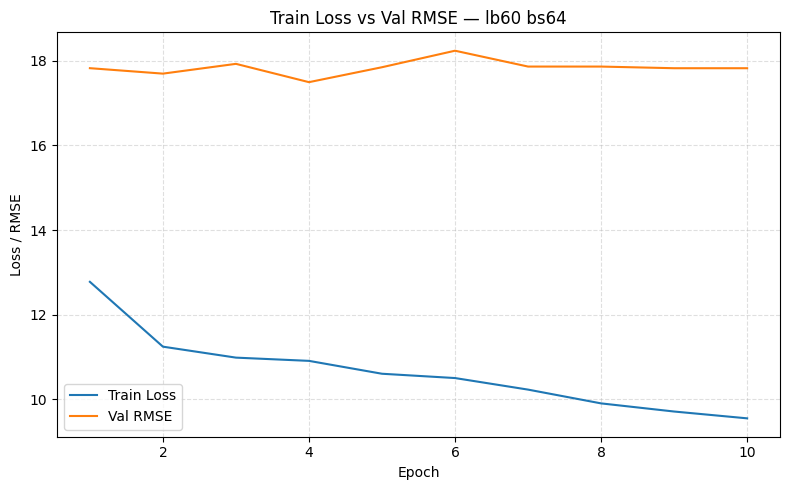

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb60_bs64.png


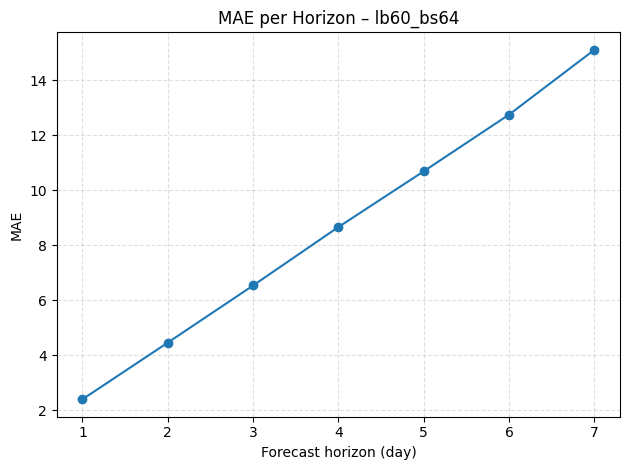

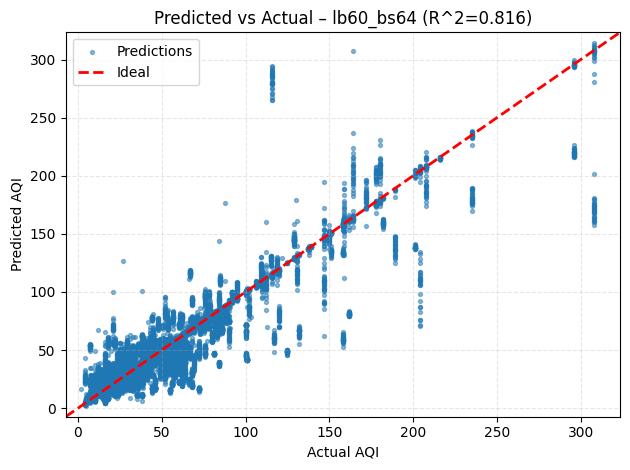

[saved] ./aqi_outputs\error_over_horizon_lb60_bs64.png
[saved] ./aqi_outputs\pred_vs_actual_lb60_bs64.png
[plan] (bs=96, lb=60) steps/epoch=454, epochs=40

=== Training start (bs=96, lb=60, min_obs=123) ===
[bs=96 lb=60] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.72315 | val Loss: 8.23583 val MAE: 8.648  RMSE: 18.064  R^2: 0.825 | lr=3.00e-04
[bs=96 lb=60] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.43224 | val Loss: 8.05835 val MAE: 8.463  RMSE: 17.629  R^2: 0.833 | lr=3.00e-04
[bs=96 lb=60] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 10.98977 | val Loss: 8.02207 val MAE: 8.412  RMSE: 17.709  R^2: 0.832 | lr=3.00e-04
[bs=96 lb=60] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.89610 | val Loss: 7.96356 val MAE: 8.353  RMSE: 17.599  R^2: 0.834 | lr=3.00e-04
[bs=96 lb=60] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.60665 | val Loss: 7.95880 val MAE: 8.355  RMSE: 17.393  R^2: 0.838 | lr=3.00e-04
[bs=96 lb=60] Epoch 06 | train (SmoothL1 + lambda*||d

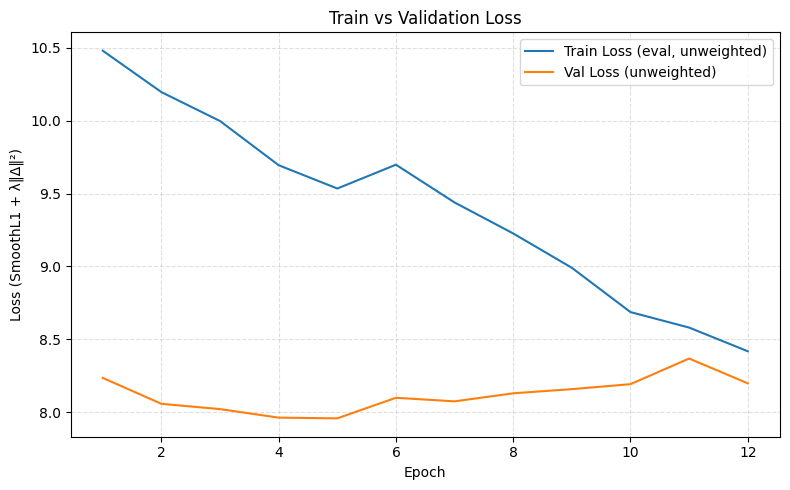

[saved] ./aqi_outputs\trainloss_vs_valloss_lb60_bs96.png


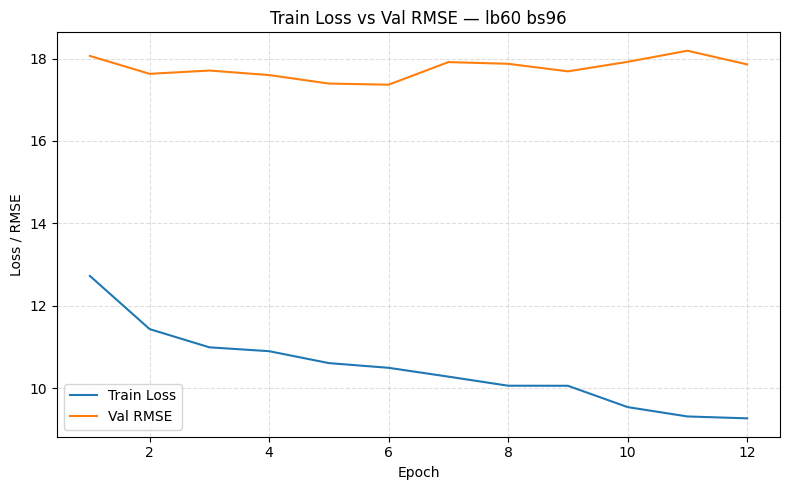

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb60_bs96.png


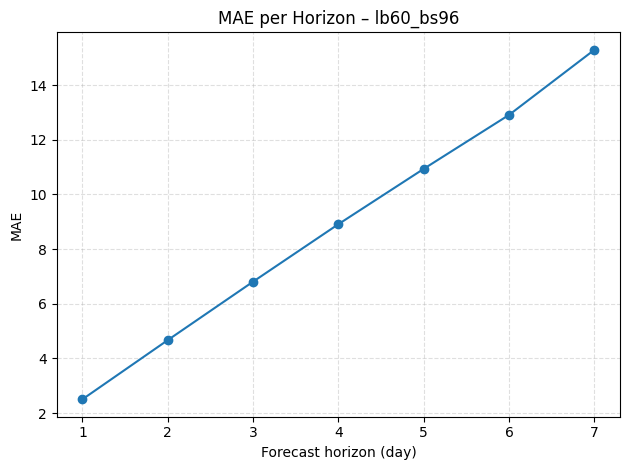

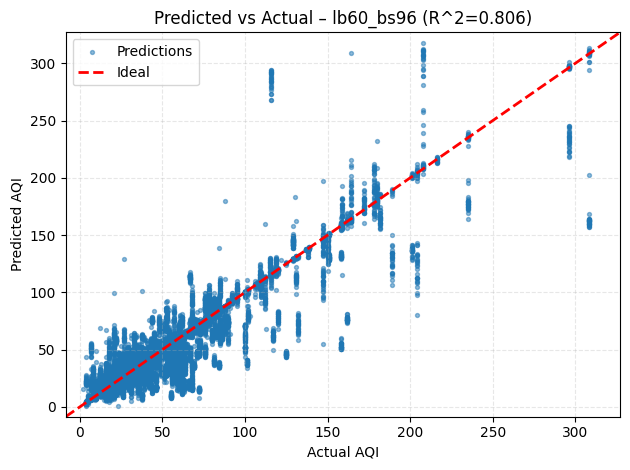

[saved] ./aqi_outputs\error_over_horizon_lb60_bs96.png
[saved] ./aqi_outputs\pred_vs_actual_lb60_bs96.png
[plan] (bs=128, lb=60) steps/epoch=340, epochs=40

=== Training start (bs=128, lb=60, min_obs=123) ===
[bs=128 lb=60] Epoch 01 | train (SmoothL1 + lambda*||delta||^2): 12.72711 | val Loss: 8.18113 val MAE: 8.601  RMSE: 18.007  R^2: 0.826 | lr=3.00e-04
[bs=128 lb=60] Epoch 02 | train (SmoothL1 + lambda*||delta||^2): 11.55319 | val Loss: 8.46122 val MAE: 8.879  RMSE: 18.150  R^2: 0.823 | lr=3.00e-04
[bs=128 lb=60] Epoch 03 | train (SmoothL1 + lambda*||delta||^2): 11.07495 | val Loss: 8.06450 val MAE: 8.470  RMSE: 17.483  R^2: 0.836 | lr=3.00e-04
[bs=128 lb=60] Epoch 04 | train (SmoothL1 + lambda*||delta||^2): 10.95246 | val Loss: 8.08244 val MAE: 8.484  RMSE: 17.747  R^2: 0.831 | lr=3.00e-04
[bs=128 lb=60] Epoch 05 | train (SmoothL1 + lambda*||delta||^2): 10.76966 | val Loss: 8.04466 val MAE: 8.440  RMSE: 17.452  R^2: 0.837 | lr=3.00e-04
[bs=128 lb=60] Epoch 06 | train (SmoothL1 + la

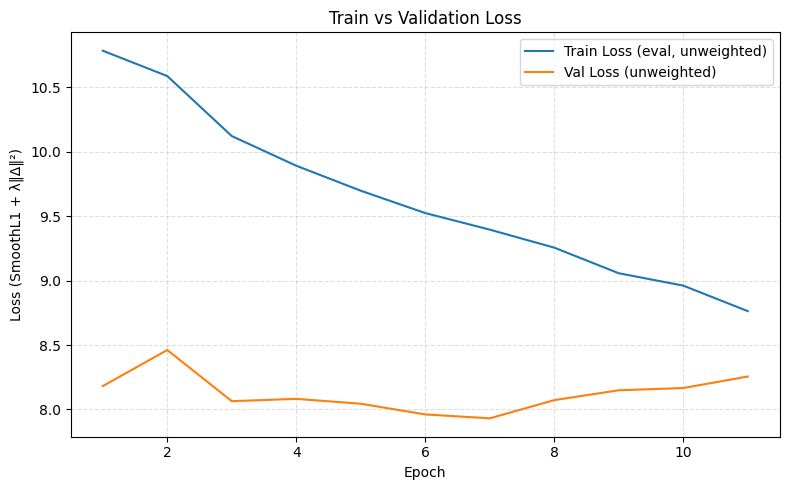

[saved] ./aqi_outputs\trainloss_vs_valloss_lb60_bs128.png


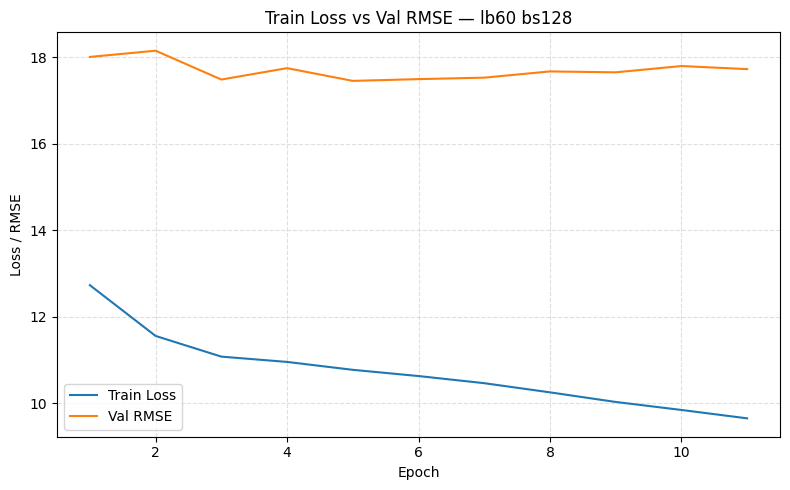

[saved] ./aqi_outputs\trainloss_vs_valrmse_lb60_bs128.png


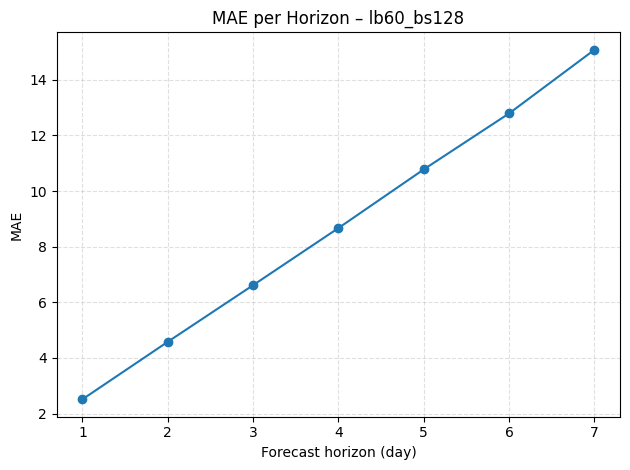

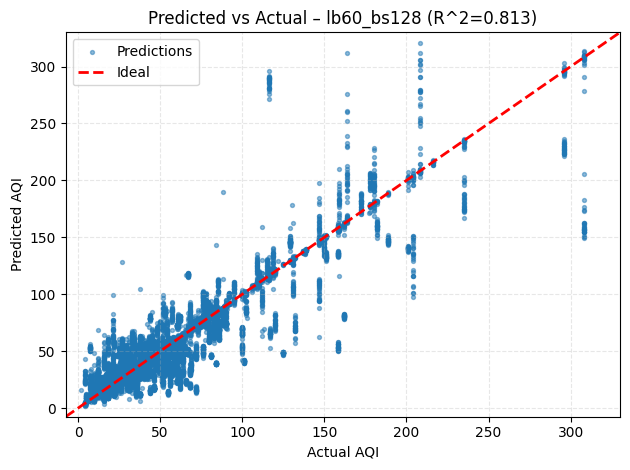

[saved] ./aqi_outputs\error_over_horizon_lb60_bs128.png
[saved] ./aqi_outputs\pred_vs_actual_lb60_bs128.png


,lookback,batch_size,min_obs,val_best_rmse,val_best_epoch,test_mae,test_rmse,test_r2,last_mae,last_rmse,last_r2,week_mae,week_rmse,week_r2
0,7,32,100,18.455009,2,9.117489,18.610198,0.777314,9.617742,20.010591,0.742539,16.588219,26.434527,0.550702
1,7,64,100,18.474194,3,9.095322,18.533307,0.779150,9.617742,20.010591,0.742539,16.588219,26.434527,0.550702
2,7,96,100,18.428007,2,9.097923,18.553862,0.778660,9.617742,20.010591,0.742539,16.588219,26.434527,0.550702
3,7,128,100,18.337713,1,9.161578,18.500929,0.779921,9.617742,20.010591,0.742539,16.588219,26.434527,0.550702
4,30,32,123,17.793734,1,8.892583,17.949792,0.797601,9.622716,20.138645,0.745229,16.466770,26.441747,0.560793
5,30,64,123,17.637222,2,8.720601,17.558809,0.806323,9.622716,20.138645,0.745229,16.466770,26.441747,0.560793
6,30,96,123,17.565726,3,8.704447,17.658203,0.804124,9.622716,20.138645,0.745229,16.466770,26.441747,0.560793
7,30,128,123,17.701072,2,8.715348,17.595617,0.805510,9.622716,20.138645,0.745229,16.466770,26.441747,0.560793
8,60,32,123,17.619819,3,8.735495,17.862616,0.808202,9.639680,20.365102,0.750697,16.574942,26.835090,0.567127
9,60,64,123,17.494162,4,8.652796,17.497566,0.815961,9.639680,20.365102,0.750697,16.574942,26.835090,0.567127


Saved sweep_results_bs_lb.csv to ./aqi_outputs


In [51]:
# Batch size × Lookback sweep 
results = []
histories = {}
for lb in SWEEP_LOOKBACKS:
    for bs in SWEEP_BATCH_SIZES:
        res, hist = run_training_experiment(lb, bs, epochs=EPOCHS)
        results.append(res)
        key = f"lb{lb}_bs{bs}"
        histories[key] = pd.DataFrame(hist)
results_df = pd.DataFrame(results).sort_values(["lookback","batch_size"]).reset_index(drop=True)
display(results_df)
os.makedirs(OUTDIR, exist_ok=True)
results_df.to_csv(os.path.join(OUTDIR, "sweep_results_bs_lb.csv"), index=False)
print("Saved sweep_results_bs_lb.csv to", OUTDIR)
